In [1]:
import time
import random

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

from scipy.integrate import solve_ivp
from scipy.stats import norm

import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as cpm

In [2]:
ALPHA = 0.2

# Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks
Pseudocode for Gillespies algorithm (Gillespie, 1977; Keeling & Rohani, 2011).
1. Label all possible events $E_1, ..., E_n.$
2. For each event determine the rate at which it occures, $R_1,...,R_n$.
3. The rate at which any event occurs is $R_{\text{total}}=\sum^{n}_{m=1}R_m$
4. The time unitl the next event is $\delta t = \frac{-1}{R_{\text{total}}}\log{(\text{RAND}_1)}$
5. Generate a new random number $\text{RAND}_2$. Set $P=\text{RAND}_2 \cdot R_{\text{total}}$
6. Event $p$ occurs if $$\sum^{p-1}_{m=1} R_m < P \leq \sum^{p}_{m=1} R_m$$
7. The time is now updated, $t \rightarrow t + \delta t$, and event $p$ is performed.
8. Return to Step 2.
## Implement Gillespies algorithm

In [3]:
def gillespie(N, S, I, beta, gamma, mu, t_max, chunk_size=1000):
    """
    Simulate an epidemic model using the Gillespie algorithm.
    At each step, the algorithm computes the rates of the following events:

    - Birth: A new susceptible individual is added to the population.
    - Infection: A susceptible individual becomes infected.
    - Recovery: An infected individual recovers and becomes immune.
    - Death of Susceptible: A susceptible individual dies.
    - Death of Infected: An infected individual dies.
    - Death of Recovered: A recovered individual dies.

    The next event and the time to that event are chosen stochastically, with the
    probabilities of events determined by their respective rates.
    For this implementation, a static list is used to speed up the process, 
    whereby extra memory will be allocated if the list is full.

    Parameters:
    ----------
    N : int
        Total population size, where N = S + I + R.
    S : int
        Initial number of susceptible individuals.
    I : int
        Initial number of infected individuals.
    beta : float
        Transmission rate, representing the likelihood of infection upon contact.
    gamma : float
        Recovery rate, indicating the rate at which infected individuals recover.
    mu : float
        Natural death rate in the population.
    t_max : float
        Maximum simulation time (in days).
    chunk_size : int, optional
        Initial memory allocation for recording history data, with more memory 
        added as needed. Default is 1000.

    Returns:
    -------
    tuple
        - history (np.ndarray): Array of shape (steps, 3) containing the susceptible, 
          infected, and recovered populations at each step.
        - t_list (list): List of time points for each recorded step.
        - extinction_event (bool): Indicator of whether the infection went extinct 
          during the simulation.
    """

    R = 0
    t_list = [0]
    extinction_event = False
    # allocate memory for history
    history = np.empty((chunk_size, 3), dtype=float)

    step = 0
    while t_list[-1] < t_max:
        rates = calc_rates(N, S, I, R, beta, gamma, mu)
        rates_total = rates.sum()
        delta_t = np.random.exponential(1/rates_total)

        P = np.random.uniform() * rates_total
        cumulative_rates = np.cumsum(rates)
        
        event_index = np.searchsorted(cumulative_rates, P)
        if event_index == 0:
            if S > 0:
                S += 1
        elif event_index == 1:
            if S > 0:
                S -= 1
                I += 1
        elif event_index == 2:
            if I > 0:
                I -= 1
                R += 1
        elif event_index == 3:
            if S > 0:
                S -= 1
        elif event_index == 4:
            if I > 0:
                I -= 1
        elif event_index == 5:
            if R > 0:
                R -= 1

        # increase the size of history if needed
        if step >= history.shape[0]:
            history = np.resize(history, (history.shape[0] + chunk_size, 3))
        history[step] = [S, I, R]

        if S <= 0 or I <= 0:
            history[step] = [np.nan, np.nan, np.nan]
            extinction_event = True

        t_list.append(t_list[-1] + delta_t)
        step += 1

    history = history[:step]
    return history, t_list, extinction_event

In [4]:
def calc_rates(N, S, I, R, beta, gamma, mu):
    """
    Calculate the rates at which different events occur based on the formula given by
    (Keeling & Rohani, 2011). 
    Each rate corresponds to addition or subtraction from a given compartment.

    Parameters:
    ----------
    N : int
        The total population size, with N = S + I + R.
    S : int
        The number of susceptible individuals in the population.
    I : int
        The number of infected individuals in the population.
    R : int
        The number of recovered individuals in the population.
    beta : float
        The transmission rate of the disease.
    gamma : float
        The recovery rate, representing the rate at which infected individuals recover.
    mu : float
        The natural death rate in the population.

    Returns:
    -------
    np.ndarray
        An array of calculated event rates, where each entry corresponds to the rate 
        of a specific event (e.g., birth, infection, recovery, death of susceptible, 
        infected, and recovered individuals).
    """
    return np.array([
        mu * N,             # Births                S = S + 1
        beta * S * I / N,   # Infection             S = S - 1, I = I + 1
        gamma * I,          # Recovery              I = I - 1, R = R + 1
        mu * S,             # Death of Susceptible  S = S - 1
        mu * I,             # Death of Infected     I = I - 1
        mu * R              # Death of Recovered    R = R - 1
    ])


def simulate(epochs, N, S, I, beta, gamma, mu, t_max, chunk_size=1000):
    """
    Simulates multiple Gillespie algorithms.
    All the outputs are added to a result and returned to the user.

    Parameters:
    ----------
    epochs : int
        The number of simulation runs or epochs to perform.
    N : int
        The total population size, with N = S + I + R.
    S : int
        The initial number of susceptible individuals in the population.
    I : int
        The initial number of infected individuals in the population.
    beta : float
        The transmission rate of the disease.
    gamma : float
        The recovery rate, representing the rate at which infected individuals recover.
    mu : float
        The natural death rate in the population.
    t_max : float
        The maximum simulation time in days for each Gillespie run.
    chunk_size : int, optional
        The interval at which data is recorded for each run. Default is 1000.

    Returns:
    -------
    tuple
        A tuple containing:
        - results (np.ndarray): Array of simulation histories for each epoch.
        - extinctions (list): List of extinction events indicating whether the infection 
          died out in each epoch.
    """
    results = []
    extinctions = []

    for _ in range(epochs):
        history, t_list, extinction_event = gillespie(
            N, S, I, beta, gamma, mu, t_max, chunk_size)
        results.append(history)
        extinctions.append(extinction_event)

    results = np.array(results, dtype=object)
    return results, extinctions


#### helper functions:

In [5]:
def calc_delta_t(rates_total):
    """
    Calculates the time interval between events in a stochastic process using 
    the total rate of the process. The time step follows an exponential distribution.
    Commonly used in simulations like the Gillespie algorithm.

    Parameters:
    ----------
    rates_total : float
        The total rate of events in the system, which influences the expected time 
        interval between stochastic events.

    Returns:
    -------
    float
        The calculated time interval (delta_t) between stochastic events, sampled 
        from an exponential distribution with rate `rates_total`.
    """
    return -np.log(np.random.uniform()) / rates_total


def calc_interpolate(results, epochs, time_points, t):
    """
    Interpolates simulation results for multiple epochs over a common set of time points. 
    Useful for normalizing different runs to a consistent time grid.

    Parameters:
    ----------
    results : np.ndarray
        A 3D array of simulation results, where each entry contains the populations
        of different compartments (S, I, R) over time for each epoch.
    epochs : int
        The number of epochs or simulation runs in the results array.
    time_points : array-like
        The common time grid over which to interpolate each epoch’s results.
    t : float
        The total duration (in days) over which each simulation run occurs.

    Returns:
    -------
    np.ndarray
        A 3D array of interpolated results with shape (epochs, 3, len(time_points)),
        aligning each epoch’s compartment values to the specified `time_points`.
    """
    results_interp = np.empty((epochs, 3, len(time_points)))

    for i in range(epochs):
        history = results[i]
        if len(history) > 0:
            t_list = np.linspace(0, t, len(history))
            results_interp[i, 0, :] = np.interp(
                time_points, t_list, history[:, 0])
            results_interp[i, 1, :] = np.interp(
                time_points, t_list, history[:, 1])
            results_interp[i, 2, :] = np.interp(
                time_points, t_list, history[:, 2])

    return results_interp


def calc_equilibrium(beta, gamma, mu):
    """
    Computes equilibrium values for susceptible and infected populations in an SIR-like model. 
    The equilibrium is based on transmission, recovery, and natural death rates.

    Parameters:
    ----------
    beta : float
        The infection rate parameter, determining the likelihood of disease spread upon contact.
    gamma : float
        The recovery rate, influencing how quickly infected individuals recover.
    mu : float
        The natural death rate, representing the rate of population exit from the susceptible group.

    Returns:
    -------
    tuple
        A tuple (S_eq, I_eq) representing the equilibrium proportions of susceptible and infected 
        populations, rounded to two decimal places.
    """
    S_eq = (gamma + mu) / beta
    I_eq = mu * (1 - S_eq) / (gamma + mu)

    return round(S_eq, 2), round(I_eq, 2)


def calc_coord(matrix, coord, value=1):
    """
    Updates a matrix at specified normalized coordinates, adding a given value. 
    Common in grid-based simulations involving spatial updates.

    Parameters:
    ----------
    matrix : np.ndarray
        A 2D array representing the spatial grid to be updated.
    coord : tuple
        A tuple of normalized coordinates (x, y), with values between 0 and 1,
        representing the position in the matrix to be updated.
    value : float, optional
        The value to add to the matrix at the specified coordinates. Default is 1.

    Returns:
    -------
    np.ndarray
        The updated matrix after the specified value has been added at the given coordinates.
    """
    detail = matrix.shape[0]
    x_index = int(coord[0] * detail)
    y_index = int(coord[1] * detail)

    if 0 <= x_index < detail and 0 <= y_index < detail:
        matrix[y_index, x_index] += value

    return matrix


def calc_last_value(arr):
    """
    Extracts the last non-NaN value from each column of a 2D array, useful for 
    time-series data with missing values. Returns the most recent valid values.

    Parameters:
    ----------
    arr : np.ndarray
        A 2D array where each column represents a time series with potential NaN values,
        indicating missing data in the series.

    Returns:
    -------
    np.ndarray
        A 1D array containing the last non-NaN value from each column in the input array.
    """
    last_values = np.empty((3, 1))

    for col in range(arr.shape[1]):
        data = arr[:, col]
        not_nan_indices = ~np.isnan(data)
        last_values[col] = data[not_nan_indices][-1]

    return last_values

#### Calculate determinisc:

In [6]:
def SIR(t, y0, N, beta, gamma, mu):
    """
    Deterministic SIR model
    """
    S, I, R = y0
    dSdt = mu * N - (beta * S * I) / N - mu * S
    dIdt = (beta * S * I) / N - gamma * I - mu * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

def calc_deterministic(t, init_values, init_param):
    """
    Solves a system of ODEs (e.g., SIR model) deterministically using given initial 
    values and parameters over time `t`. It returns the solution for all compartments.
    
    Parameters:
    ----------
    t : array-like
        Array of time points (in days) at which to solve the system.
    init_values : list or array-like
        Initial values of the compartments, typically [S, I, R].
    init_param : list or array-like
        Parameters for the SIR model, including [N, beta, gamma, mu].

    Returns:
    -------
    np.ndarray
        A 2D array where each row corresponds to the solution trajectory of a compartment (S, I, R) over time.
    """
    t_eval = np.linspace(0, t[-1], len(t))
    sol = solve_ivp(SIR, [0, t[-1]], y0=init_values, args=init_param, t_eval=t_eval, dense_output=True)
    return sol.y

#### Plot functions:

In [7]:
def plot_simulation(results, extinctions, epochs, N, S, I, beta, gamma, mu, t):
    """
    Plots the stochastic Gillespie simulation trajectories over multiple epochs for an SIR model,
    along with the deterministic solution and the mean trajectory across epochs. This function 
    illustrates the variance and convergence of the simulated trajectories to the deterministic model.

    Parameters:
    ----------
    results : np.ndarray
        A 3D array containing the population of Susceptible, Infected, and Removed individuals over
        time for each epoch. Shape is (epochs, 3, time_steps).
    extinctions : list or np.ndarray
        A list or array indicating whether extinction (zero infected individuals) occurred in each epoch.
    epochs : int
        The number of epochs or simulation runs performed for the Gillespie algorithm.
    N : int
        The total initial population, where N = S + I + R (Susceptible, Infected, Recovered).
    S : int
        The initial count of susceptible individuals at the start of the simulation.
    I : int
        The initial count of infected individuals at the start of the simulation.
    beta : float
        The disease transmission rate, representing the probability of infection upon contact.
    gamma : float
        The recovery rate, indicating how quickly infected individuals recover and become immune.
    mu : float
        The natural death rate or rate of exit from the population, if considered in the model.
    t : float
        The total time duration (in days) for which the simulation is run.
    time_points = np.linspace(0, t, 1000)
    results_interp = calc_interpolate(results, epochs, time_points, t)
    """
    time_points = np.linspace(0, t, 1000)
    results_interp = calc_interpolate(results, epochs, time_points, t)

    plt.figure(figsize=(12, 6))    
    for i in range(epochs):
        plt.plot(time_points, results_interp[i, 0, :], color='blue', alpha=ALPHA)
        plt.plot(time_points, results_interp[i, 1, :], color='red', alpha=ALPHA)
        plt.plot(time_points, results_interp[i, 2, :], color='green', alpha=ALPHA)

    sol = calc_deterministic(time_points, [S, I, 0], [N, beta, gamma, mu])
    plt.plot(time_points, sol[0], color='blue', linestyle='dashed')
    plt.plot(time_points, sol[1], color='red', linestyle='dashed')
    plt.plot(time_points, sol[2], color='green', linestyle='dashed')

    mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
    mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
    mean_R = np.nanmean(results_interp[:, 2, :], axis=0)
    plt.plot(time_points, mean_S, color='blue', linewidth=2)
    plt.plot(time_points, mean_I, color='red', linewidth=2)
    plt.plot(time_points, mean_R, color='green', linewidth=2)

    custom_legends = [
        Line2D([0], [0], color='black', linestyle='-', label='Mean'),
        Line2D([0], [0], color='black', linestyle='--', label='Deterministic'),
        Line2D([0], [0], color='blue', label='Susceptible'),
        Line2D([0], [0], color='red', label='Infected'),
        Line2D([0], [0], color='green', label='Removed')
    ]
    
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title(f'Gillespie Simulation Over {epochs} Epochs (SIR Model)\n Extinctions: {sum(extinctions)}, β={beta}, γ={gamma}, μ={mu}')
    plt.grid()    
    plt.legend(handles=custom_legends, loc='best')    
    plt.show()
    
def plot_variance(epochs, N, S, I, beta, gamma, mu, t):
    """
    Plots the mean infected population over time for a Gillespie simulation of the SIR model,
    along with its comparison to the deterministic solution of the model. It highlights the variance
    between the stochastic and deterministic infected population trajectories.

    Parameters:
    ----------
    epochs : int
        The number of simulation runs or epochs to conduct for the Gillespie algorithm.
    N : int
        The total population size used in the model, with N = S + I + R (Susceptible, Infected, Recovered).
    S : int
        The initial number of susceptible individuals in the population.
    I : int
        The initial number of infected individuals in the population.
    beta : float
        The transmission rate of the disease, representing the likelihood of infection upon contact.
    gamma : float
        The recovery rate, representing the rate at which infected individuals recover and gain immunity.
    mu : float
        The natural death rate or rate of exit from the population, if applicable in the model.
    t : float
        The total duration (in days) for which the simulation is run.
    """
    
    time_points = np.linspace(0, t, 1000)
    results, _ = simulate(epochs, N, S, I, beta, gamma, mu, t)
    results_interp = calc_interpolate(results, epochs, time_points, t)

    I_mean = np.nanmean(results_interp[:, 1, :], axis=0)

    plt.figure(figsize=(12, 6))
    sol = calc_deterministic(time_points, [S, I, 0], [N, beta, gamma, mu])
    plt.plot(time_points, sol[1], color='red', label='Infected deterministic' ,linestyle='dashed')
    plt.plot(time_points, I_mean, color='red', label='Infected mean')
    plt.fill_between(time_points, sol[1], I_mean, color='red', alpha=0.2)

    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.title(
        f'Gillespie Simulation Over {epochs} Epochs (SIR Model)\n β={beta}, γ={gamma}, μ={mu}')
    plt.grid()
    plt.legend()
    plt.show()

def plot_variance_covariance(beta_values, gamma_values, time_points, mean_S_results, mean_I_results, var_S_results, var_I_results, covariances):
    """
    Plots the mean susceptible and infected populations over time along with their variances
    and covariance for varying model parameters (beta and gamma).

    Parameters:
    ----------
    beta_values : list of float
        A list of transmission rates (beta) used in the simulations.

    gamma_values : list of float
        A list of recovery rates (gamma) used in the simulations.

    time_points : array
        An array of time points at which the mean populations and their variances are calculated.

    mean_S_results : list of array
        A list containing the mean susceptible populations for each combination of beta and gamma
        across the specified time points.

    mean_I_results : list of array
        A list containing the mean infected populations for each combination of beta and gamma
        across the specified time points.

    var_S_results : list of array
        A list containing the variances of susceptible populations for each combination of beta
        and gamma across the specified time points.

    var_I_results : list of array
        A list containing the variances of infected populations for each combination of beta
        and gamma across the specified time points.

    covariances : list of float
        A list of covariance values calculated between the susceptible (S) and infected (I)
        populations for each beta and gamma combination.

    Returns:
    -------
    Plots that display mean susceptible and infected populations, the variance as shaded areas, and the numerical output for covariance.
    """
    num_betas = len(beta_values)
    num_gammas = len(gamma_values)
    fig, axs = plt.subplots(num_betas, num_gammas, figsize=(20, 12), constrained_layout=False)

    for i, beta in enumerate(beta_values):
        for j, gamma in enumerate(gamma_values):
            ax = axs[i, j]
            R0 = beta / (gamma + mu)
            idx = i * num_gammas + j
            ax.plot(time_points, mean_S_results[idx], color='blue', label='Mean Susceptible', linewidth=2)
            ax.plot(time_points, mean_I_results[idx], color='red', label='Mean Infected', linewidth=2)

            ax.fill_between(time_points,
                            mean_S_results[idx] - np.sqrt(var_S_results[idx]),
                            mean_S_results[idx] + np.sqrt(var_S_results[idx]),
                            color='blue', alpha=0.2)
            ax.fill_between(time_points,
                            mean_I_results[idx] - np.sqrt(var_I_results[idx]),
                            mean_I_results[idx] + np.sqrt(var_I_results[idx]),
                            color='red', alpha=0.2)

            ax.set_title(f'β={beta:.2f}, γ={gamma:.2f}, R0={R0:.2f}')
            ax.set_xlabel('Time (days)', fontsize=12)
            ax.set_ylabel('Population', fontsize=12)
            ax.grid()
            ax.legend()
            ax.text(0.5, -0.2, f'Covariance S-I: {covariances[idx]:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=10)

    plt.subplots_adjust(bottom=0.15)
    plt.tight_layout()
    plt.show()

---------
## Investigate Simulation Variability and Negative Co-variance
#### Init values and params:

In [8]:
beta_list = [1.67, 1.2, 2.0]
gamma_list = [0.47, 0.3, 0.6]

beta = 0.3
gamma = 0.1
mu = 0.01
t = 356

N = 10e3
I = N // 100
S = N - I

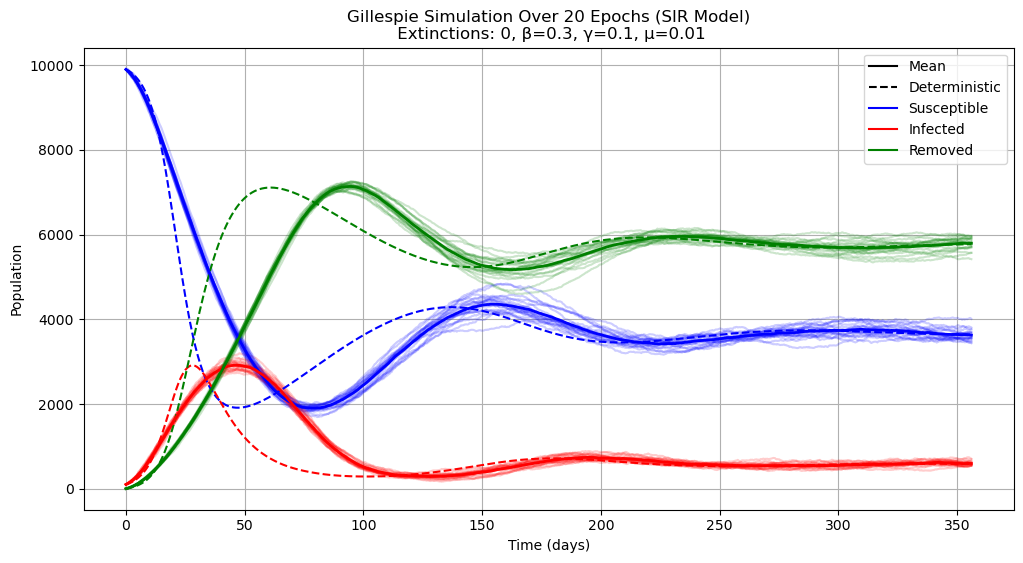

CPU times: user 37.8 s, sys: 213 ms, total: 38 s
Wall time: 37.9 s


In [9]:
%%time
epochs = 20
results, extinsions = simulate(epochs, N, S, I, beta, gamma, mu, t)
plot_simulation(results, extinsions, epochs, N, S, I, beta, gamma, mu, t)

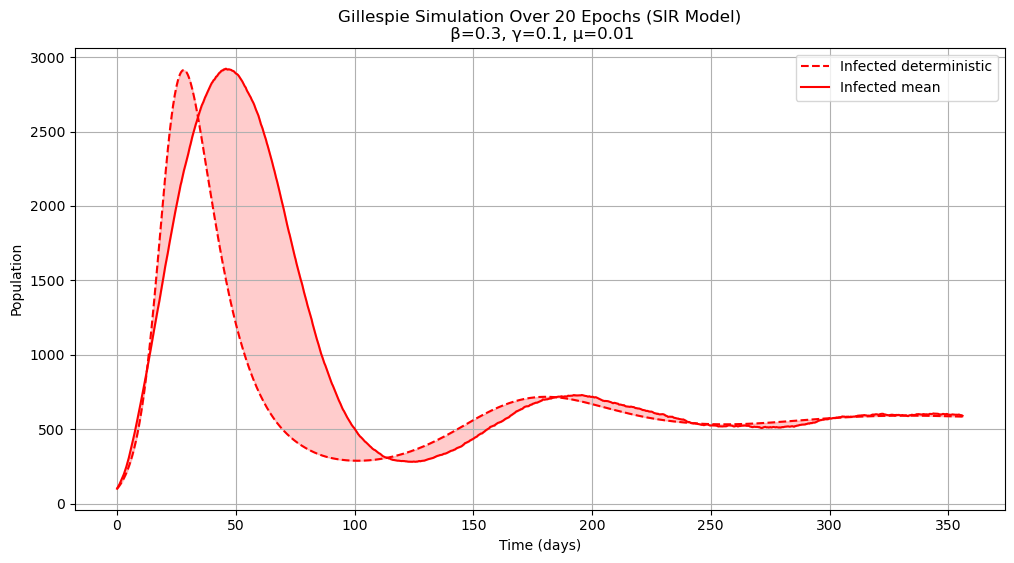

In [10]:
plot_variance(epochs, N, S, I, beta, gamma, mu, t)

In [11]:
N_start = 10e1
N_values = [N_start * factor for factor in [0.5, 1.0, 5.0, 10.0, 100.0, 1000.0]]
I = N_start // 100
S = N_start - I
beta_start=0.3
beta_values = [beta_start * factor for factor in [1, 2, 3, 4]]
gamma_start = 0.1
gamma_values = [gamma_start * factor for factor in [1, 2, 3, 4]]
mu_start = 0.01
mu_values = [mu_start * factor for factor in [1, 2, 3, 4]]
t = 365
epochs = 20

β = 0.3, Time taken: 0.45 seconds


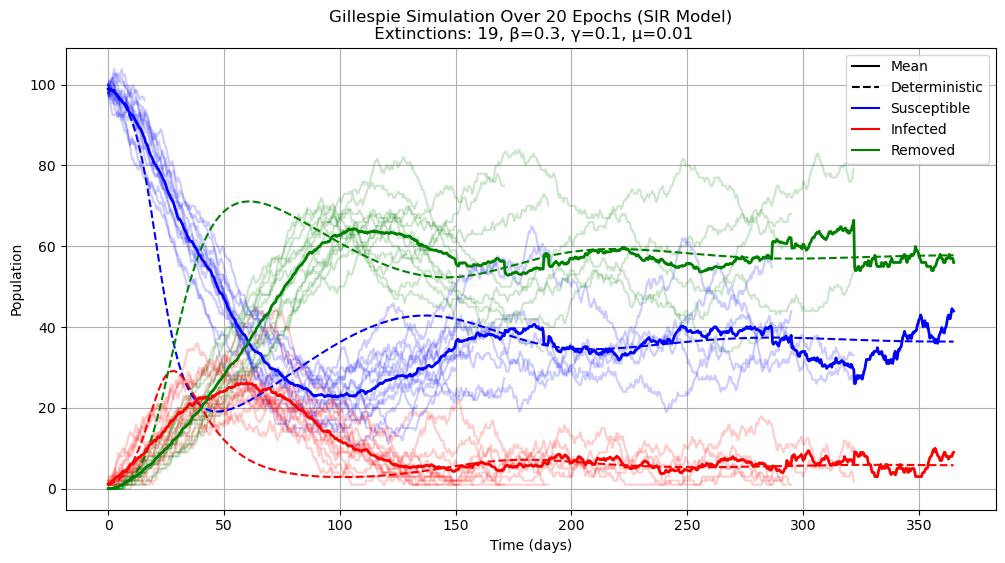

β = 0.6, Time taken: 0.31 seconds


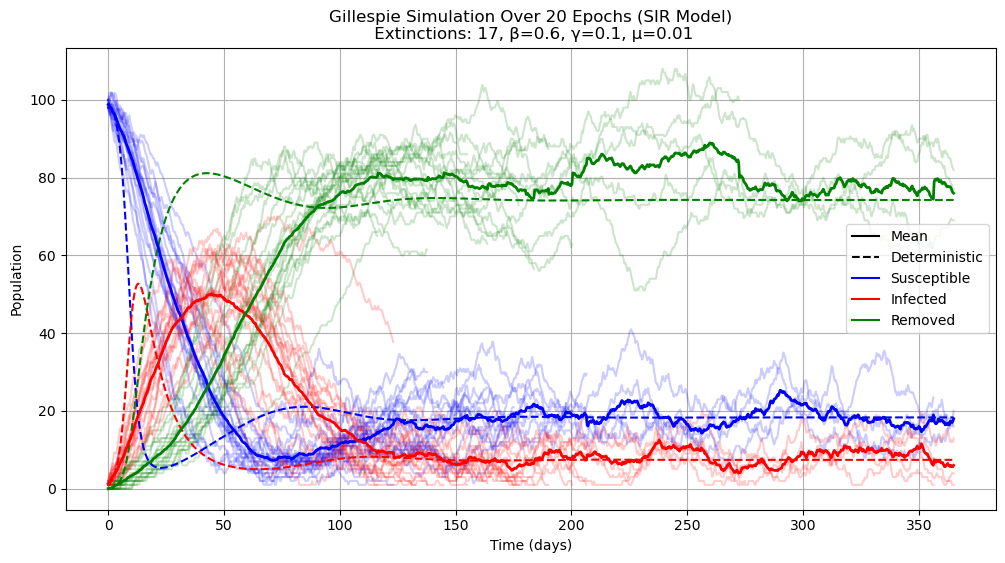

β = 0.9, Time taken: 0.28 seconds


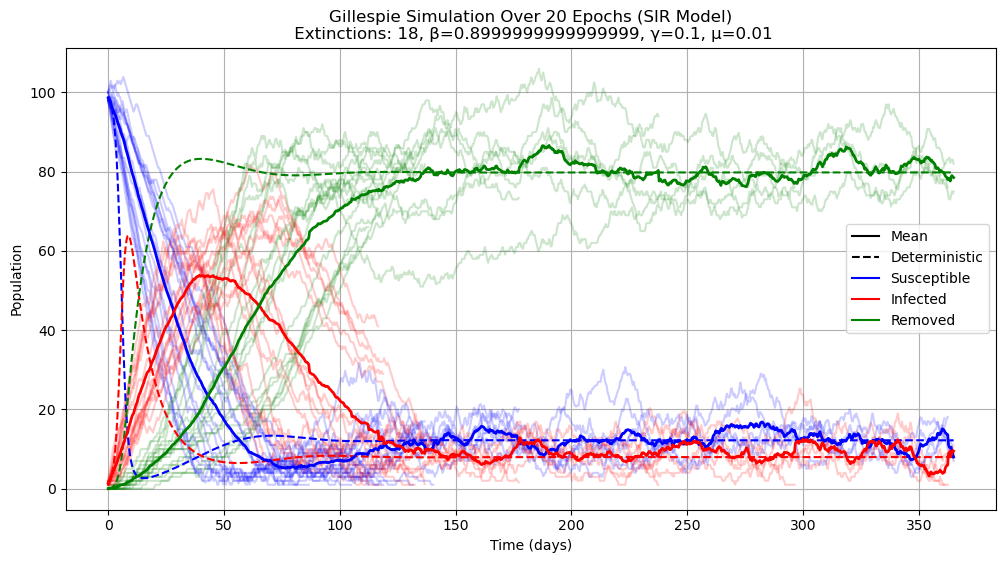

β = 1.2, Time taken: 0.24 seconds


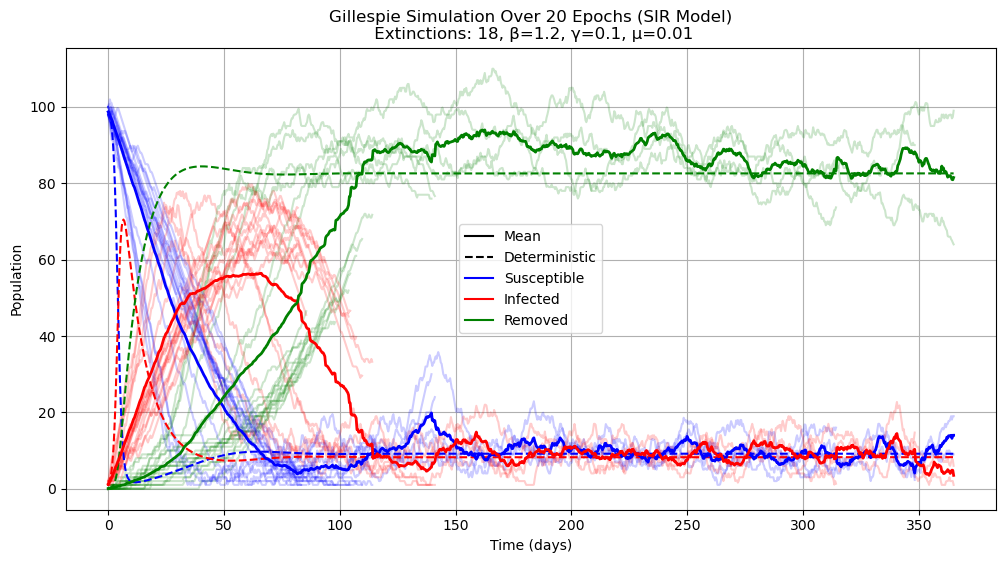

In [12]:
#Plotting transients for different beta
for beta in beta_values:
    start_time = time.time()
    results, extinctions = simulate(epochs, N_start, S, I, beta, gamma_start, mu_start, t)
    end_time = time.time()
    print(f"β = {round(beta,2)}, Time taken: {end_time - start_time:.2f} seconds")
    plot_simulation(results, extinctions, epochs, N_start, S, I, beta, gamma_start, mu_start, t)

N = 50.0, Time taken: 0.18 seconds


/tmp/ipykernel_32276/3514066204.py:47: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:48: RuntimeWarning: Mean of empty slice
  mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:49: RuntimeWarning: Mean of empty slice
  mean_R = np.nanmean(results_interp[:, 2, :], axis=0)


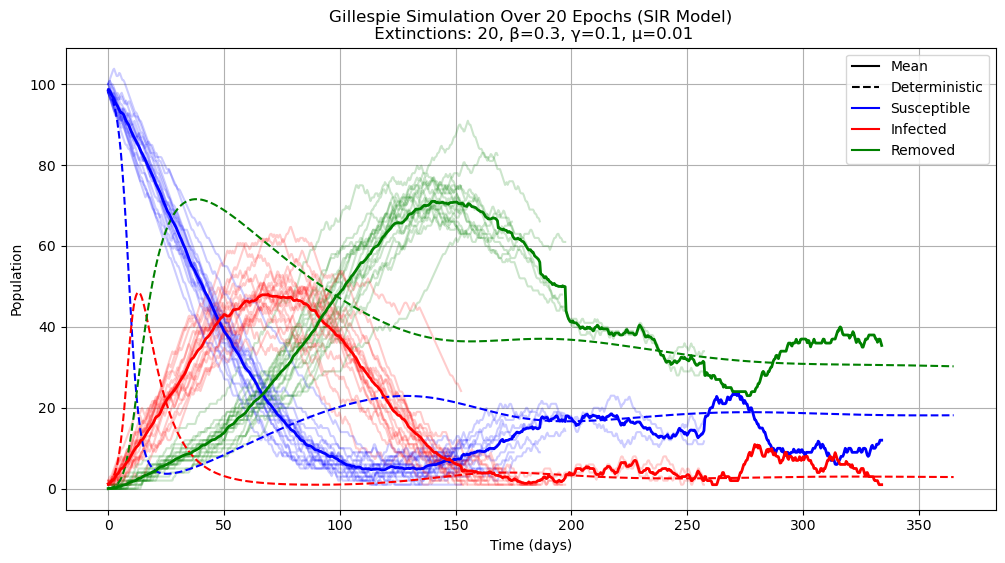

N = 100.0, Time taken: 0.26 seconds


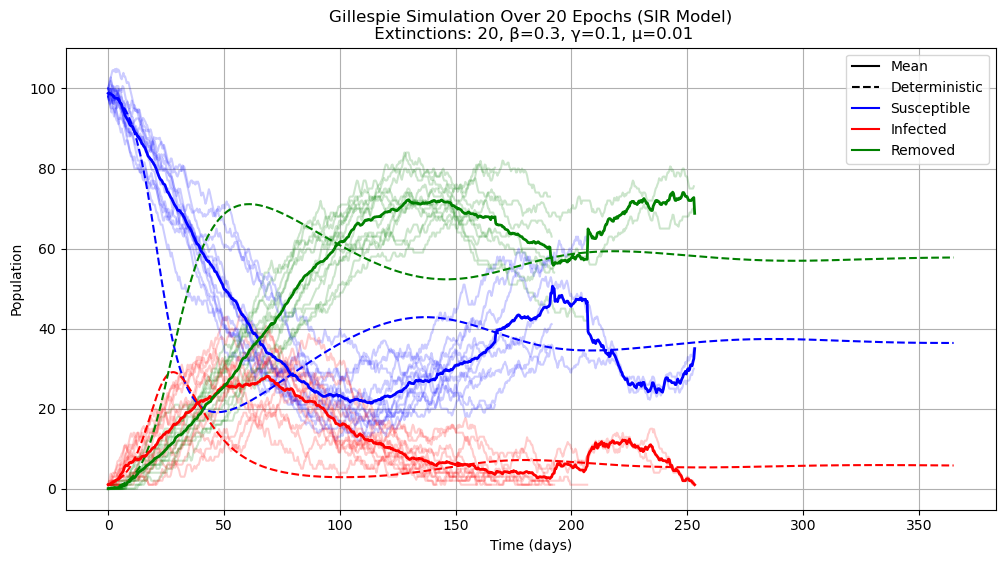

N = 500.0, Time taken: 0.91 seconds


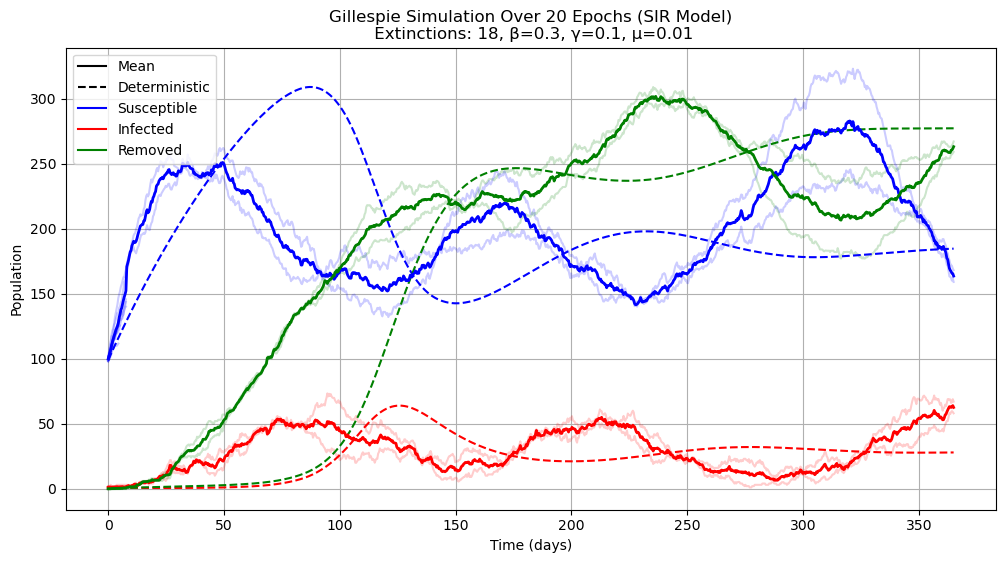

N = 1000.0, Time taken: 1.76 seconds


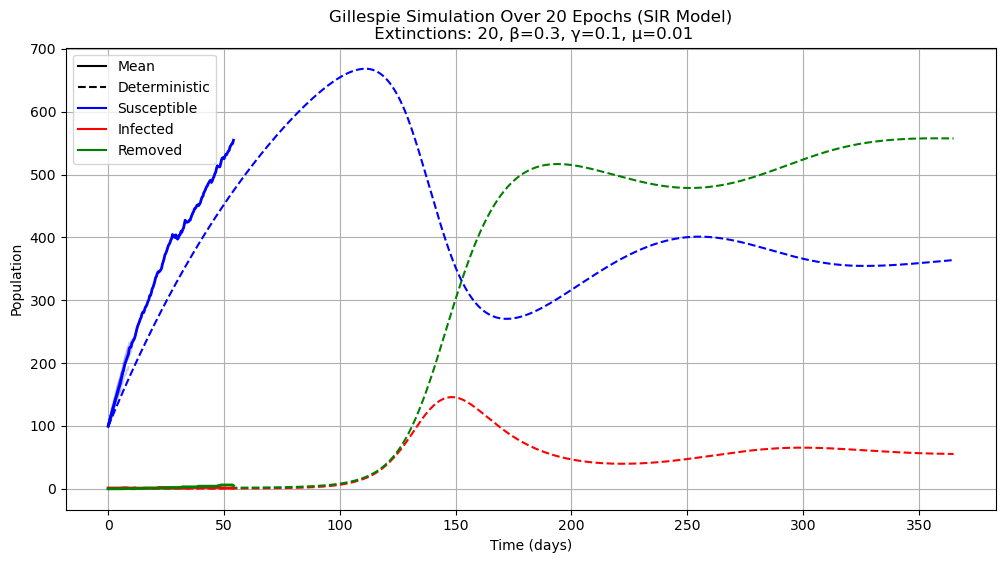

N = 10000.0, Time taken: 18.27 seconds


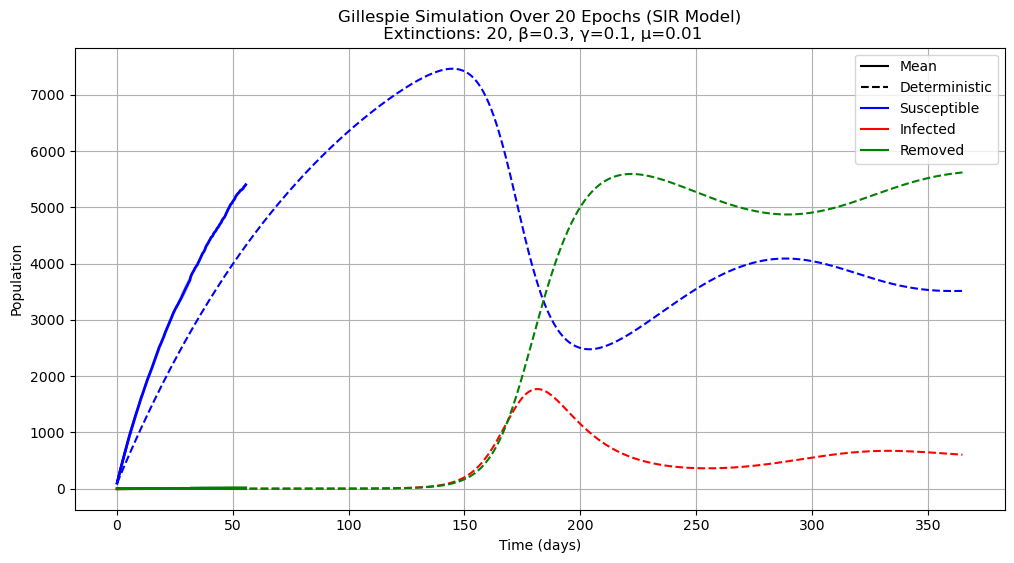

N = 100000.0, Time taken: 199.09 seconds


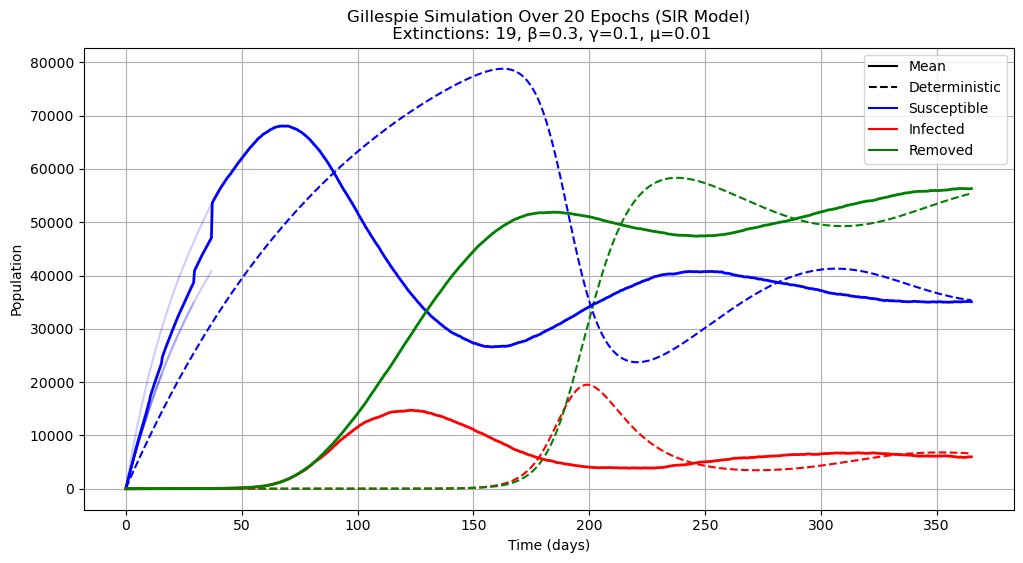

In [13]:
#Plotting transients for different N
for N in N_values:
    start_time = time.time()
    results, extinctions = simulate(epochs, N, S, I, beta_start, gamma_start, mu_start, t)
    end_time = time.time()
    print(f"N = {N}, Time taken: {end_time - start_time:.2f} seconds")
    plot_simulation(results, extinctions, epochs, N, S, I, beta_start, gamma_start, mu_start, t)

γ = 0.1, Time taken: 0.32 seconds


/tmp/ipykernel_32276/3514066204.py:47: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:48: RuntimeWarning: Mean of empty slice
  mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:49: RuntimeWarning: Mean of empty slice
  mean_R = np.nanmean(results_interp[:, 2, :], axis=0)


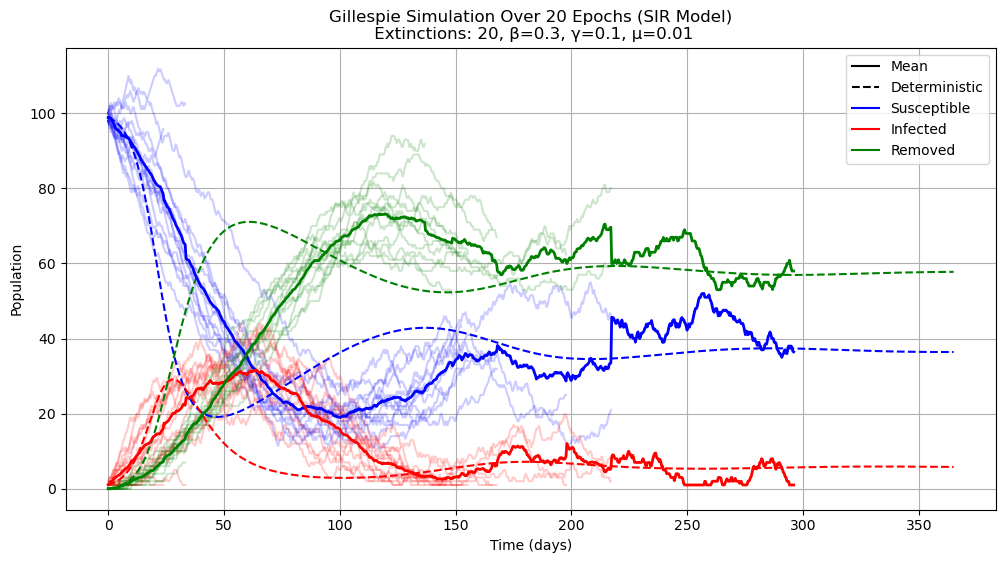

γ = 0.2, Time taken: 0.28 seconds


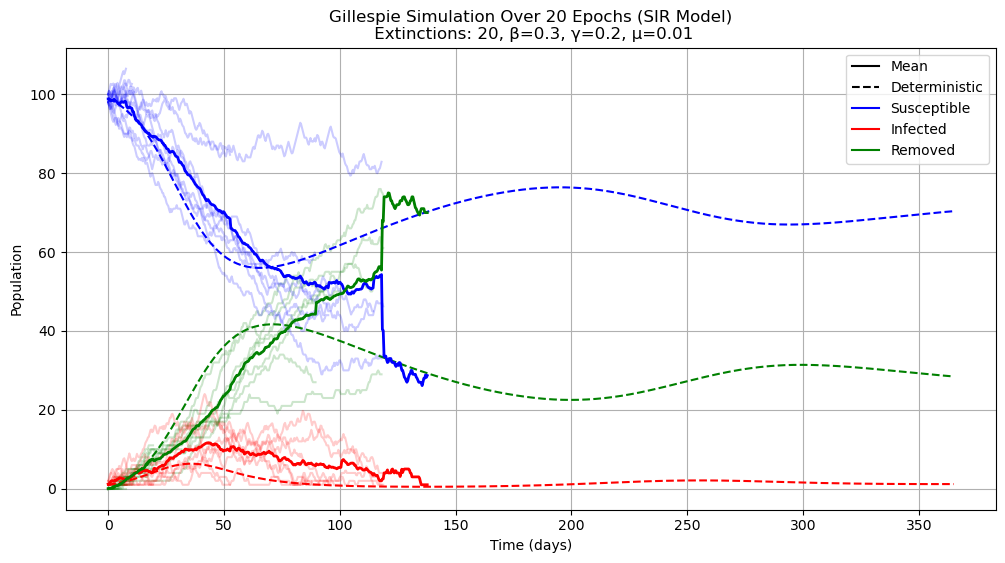

γ = 0.30000000000000004, Time taken: 0.23 seconds


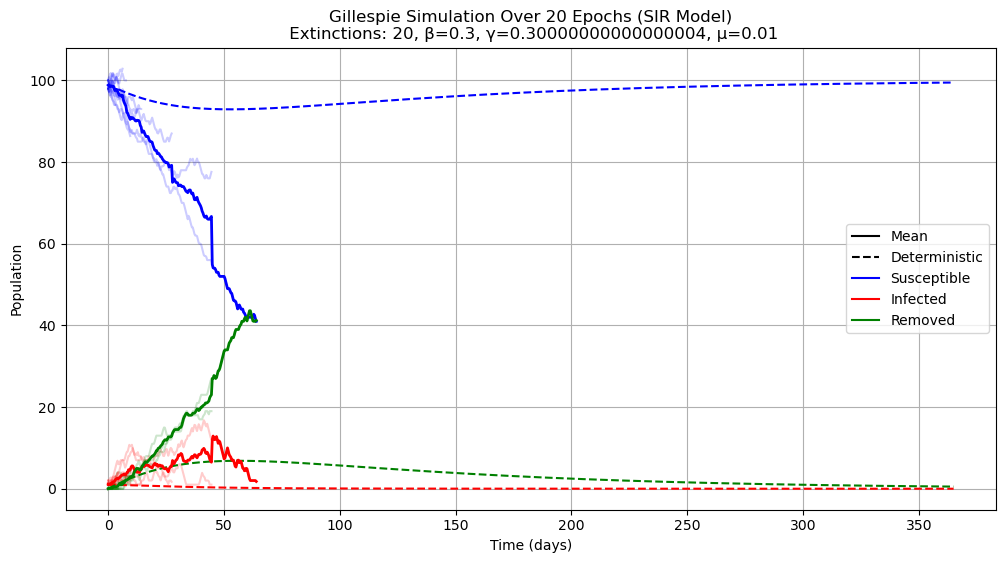

γ = 0.4, Time taken: 0.20 seconds


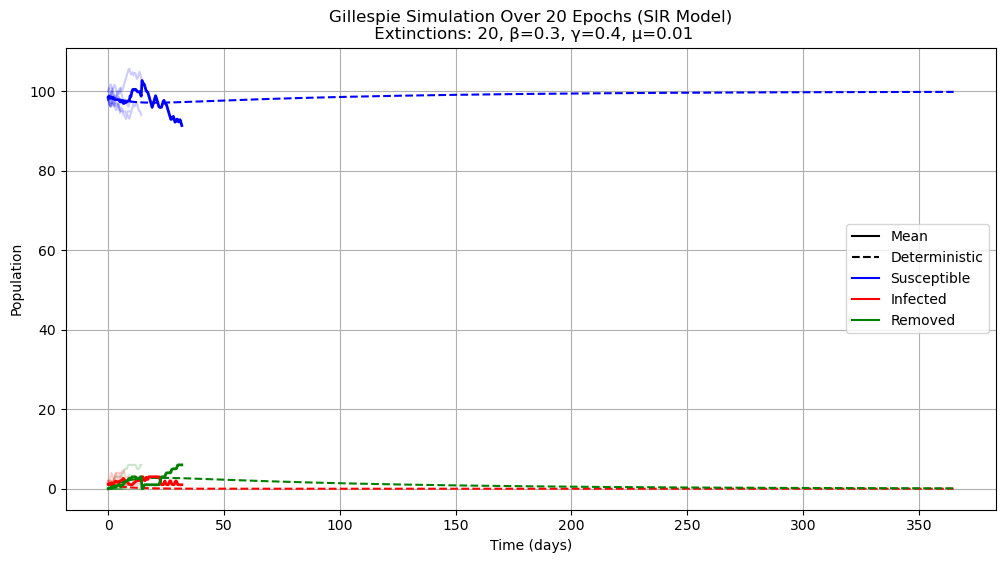

In [14]:
#Plotting transients for different gamma
for gamma in gamma_values:
    start_time = time.time()
    results, extinctions = simulate(epochs, N_start, S, I, beta_start, gamma, mu_start, t)
    end_time = time.time()
    print(f"γ = {gamma}, Time taken: {end_time - start_time:.2f} seconds")
    plot_simulation(results, extinctions, epochs, N_start, S, I, beta_start, gamma, mu_start, t)

µ = 0.01, Time taken: 0.34 seconds


/tmp/ipykernel_32276/3514066204.py:47: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:48: RuntimeWarning: Mean of empty slice
  mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
/tmp/ipykernel_32276/3514066204.py:49: RuntimeWarning: Mean of empty slice
  mean_R = np.nanmean(results_interp[:, 2, :], axis=0)


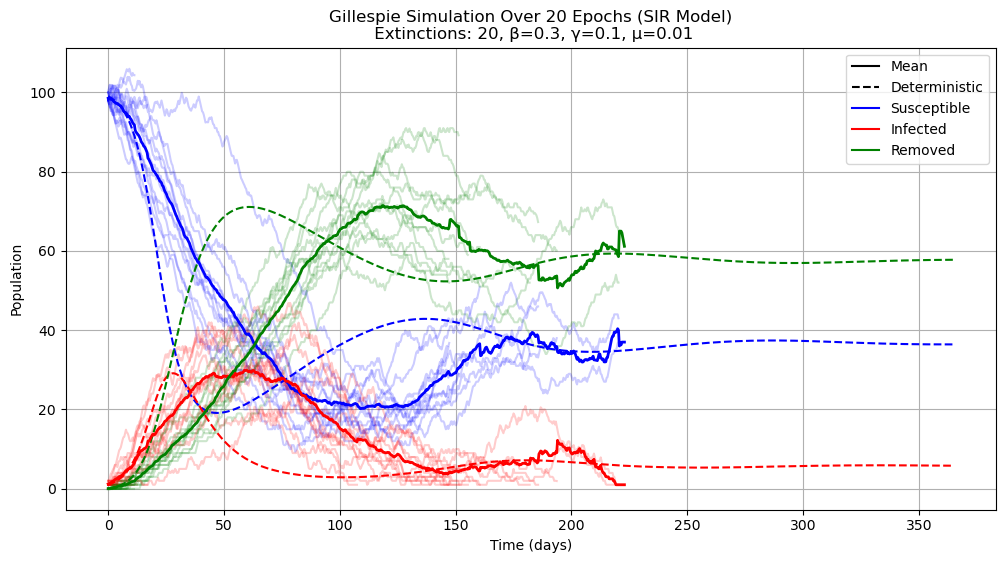

µ = 0.02, Time taken: 0.48 seconds


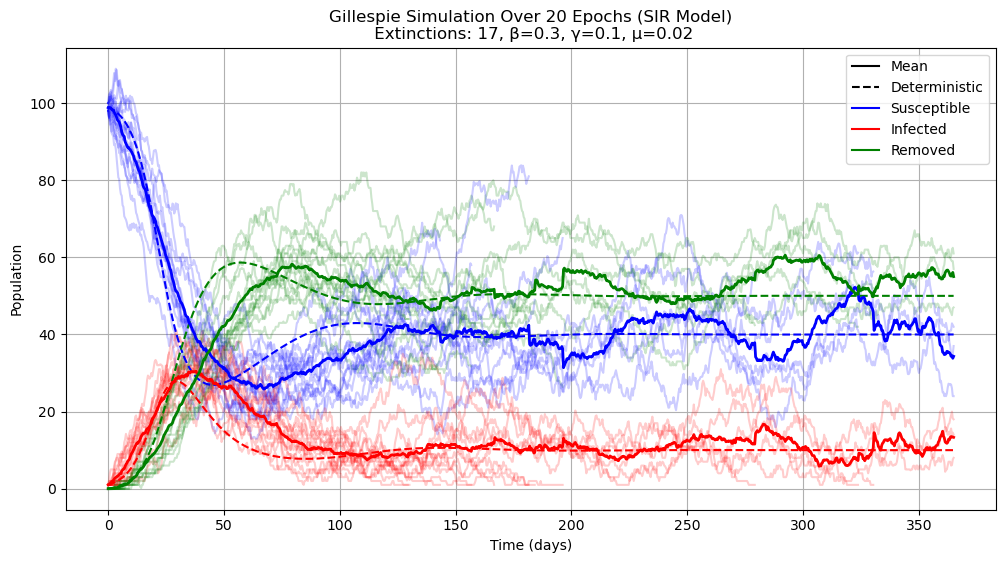

µ = 0.03, Time taken: 0.64 seconds


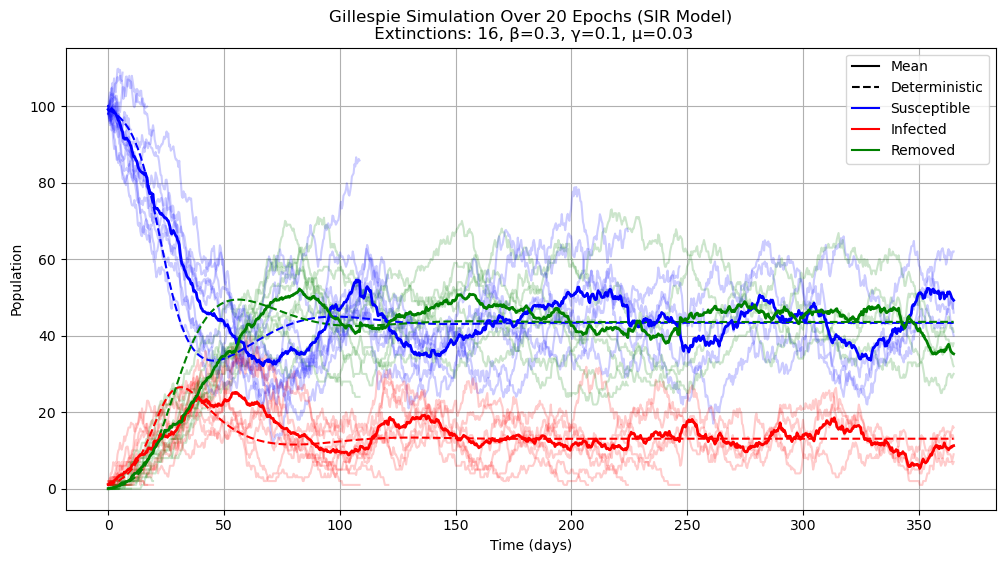

µ = 0.04, Time taken: 0.81 seconds


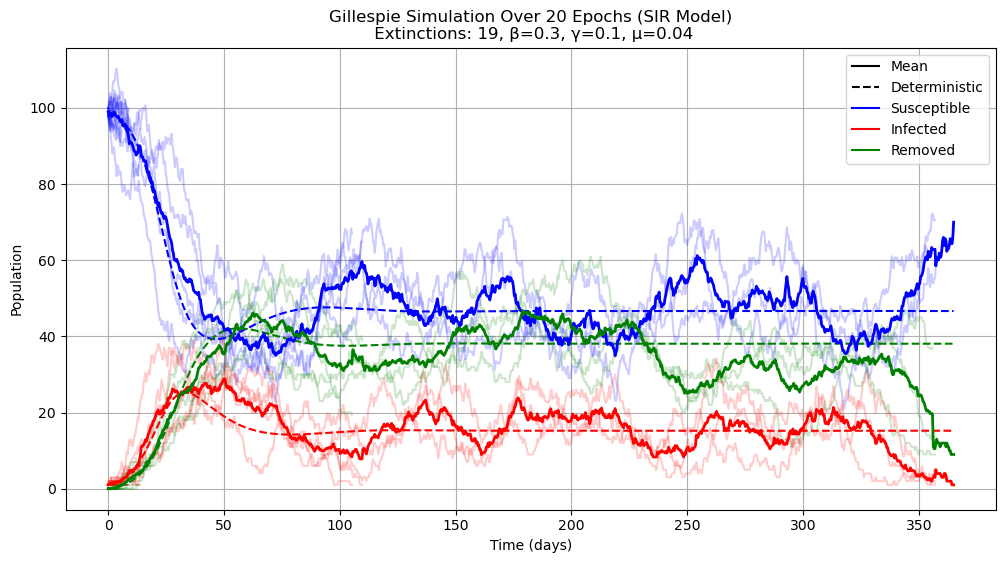

In [15]:
#Plotting transients for different mu
for mu in mu_values:
    start_time = time.time()
    results, extinctions = simulate(epochs, N_start, S, I, beta_start, gamma_start, mu, t)
    end_time = time.time()
    print(f"µ = {mu}, Time taken: {end_time - start_time:.2f} seconds")
    plot_simulation(results, extinctions, epochs, N_start, S, I, beta_start, gamma_start, mu, t)

In [16]:
PARAM_COUNT = 3  # How many values will be added to the param list, resulting in x^2 loops.
beta_values = np.linspace(0.5, 2, PARAM_COUNT)
gamma_values = np.linspace(0.1, 1, PARAM_COUNT)

num_beta = len(beta_values)
num_gamma = len(gamma_values)
N = 10e2

In [17]:
mean_S_results = []
mean_I_results = []
covariances = []
var_S_results = []
var_I_results = []

/tmp/ipykernel_32276/2624170885.py:8: RuntimeWarning: Mean of empty slice
  mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
/tmp/ipykernel_32276/2624170885.py:9: RuntimeWarning: Mean of empty slice
  mean_I = np.nanmean(results_interp[:, 1, :], axis=0)
/tmp/ipykernel_32276/2624170885.py:11: RuntimeWarning: Mean of empty slice
  covariance = np.nansum((results_interp[:, 0, :] - np.nanmean(results_interp[:, 0, :], axis=0)) *
/tmp/ipykernel_32276/2624170885.py:12: RuntimeWarning: Mean of empty slice
  (results_interp[:, 1, :] - np.nanmean(results_interp[:, 1, :], axis=0)), axis=0) / (N - 1)
/tmp/ipykernel_32276/2624170885.py:16: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_S = np.nanvar(results_interp[:, 0, :], axis=0)
/tmp/ipykernel_32276/2624170885.py:17: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var_I = np.nanvar(results_interp[:, 1, :], axis=0)


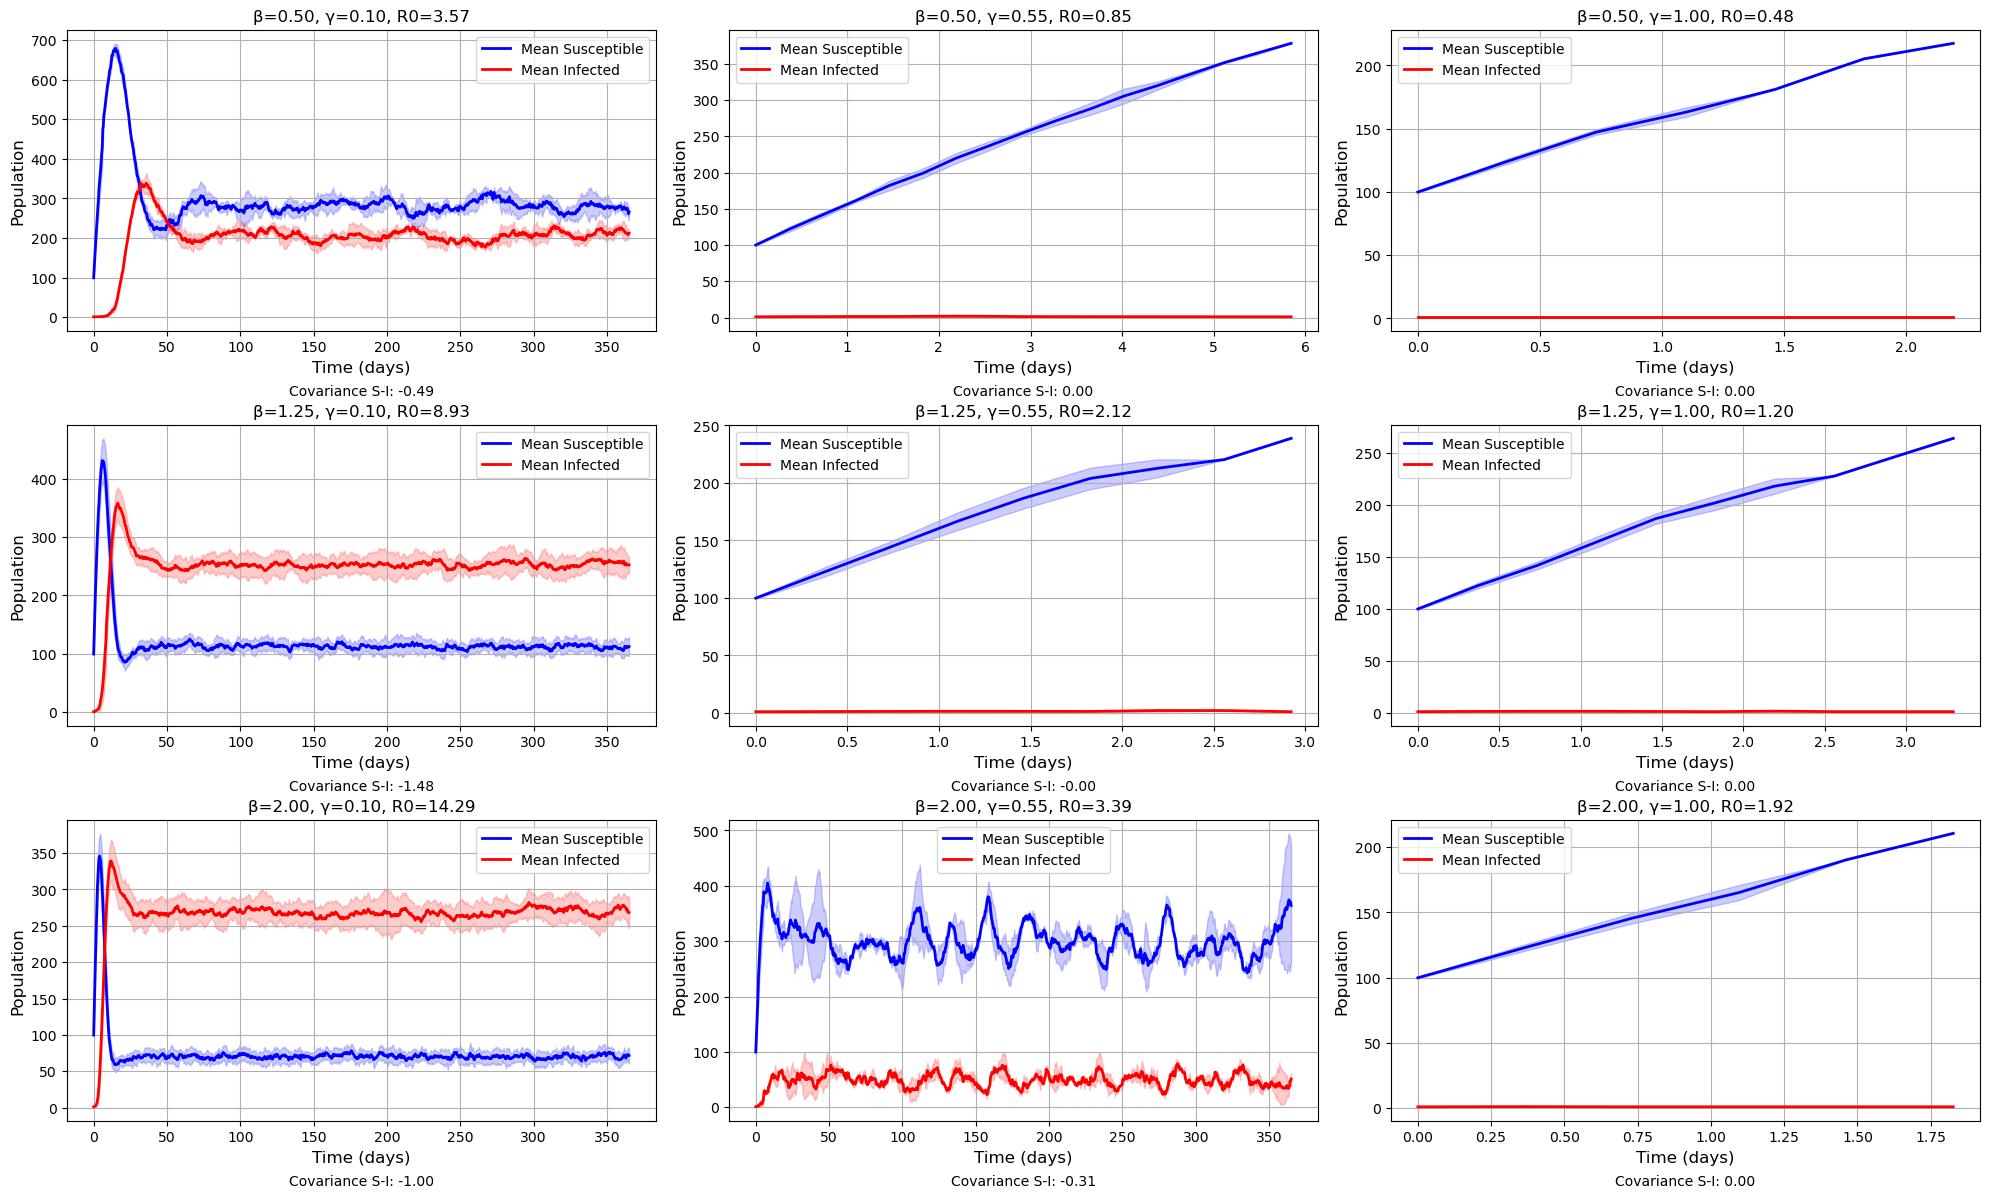

In [18]:
for beta in beta_values:
    for gamma in gamma_values:
        results, extinctions = simulate(epochs, N, S, I, beta, gamma, mu, t)

        time_points = np.linspace(0, t, 1000)
        results_interp = calc_interpolate(results, epochs, time_points, t)

        mean_S = np.nanmean(results_interp[:, 0, :], axis=0)
        mean_I = np.nanmean(results_interp[:, 1, :], axis=0)

        covariance = np.nansum((results_interp[:, 0, :] - np.nanmean(results_interp[:, 0, :], axis=0)) *
                                (results_interp[:, 1, :] - np.nanmean(results_interp[:, 1, :], axis=0)), axis=0) / (N - 1)

        covariance_scalar = np.nanmean(covariance)

        var_S = np.nanvar(results_interp[:, 0, :], axis=0)
        var_I = np.nanvar(results_interp[:, 1, :], axis=0)

        mean_S_results.append(mean_S)
        mean_I_results.append(mean_I)
        var_S_results.append(var_S)
        var_I_results.append(var_I)
        covariances.append(covariance_scalar)

plot_variance_covariance(beta_values, gamma_values, time_points, mean_S_results, mean_I_results, var_S_results, var_I_results, covariances)

---------
## Stochastic Resonance and Increased Transients

In [19]:
def plot_phase(N, epochs, beta, gamma, mu, lines, t):
    time_points = np.linspace(0, t, 1000)
    colors = sns.color_palette(None, lines)
    plt.figure(figsize=(12, 6))
    custom_legends = []

    for color, infected_porpotion in zip(colors, np.linspace(0.01, 0.9, lines)):
        I = int(N * infected_porpotion)
        S = N - I
        results, _ = simulate(epochs, N, S, I, beta, gamma, mu, t)
        results_interp = calc_interpolate(results, epochs, time_points, t)

        for i in range(epochs):
            plt.plot(results_interp[i, 0, :],
                    results_interp[i, 1, :], color=color, alpha=0.1)
        custom_legends.append(Line2D([0], [0], color=color, label=f"Init infected:{int(N * infected_porpotion)}"))
            
    x_equilibrium, y_equilibrium = calc_equilibrium(beta, gamma, mu)
    plt.scatter(x_equilibrium * N, y_equilibrium * N, 
                color='red', edgecolor='black', s=100, zorder=5, label='Equilibrium Point')

    plt.xlabel('Suseptible Population (S)')
    plt.xlim(-10, N)
    plt.ylabel('Infected Population (I)')
    plt.ylim(-10, N)
    plt.title(
        f'Phase Space Over {epochs} Epochs (SIR Model)\n β={beta}, γ={gamma}, μ={mu}')
    plt.grid()
    plt.legend(handles=custom_legends, loc='best')    
    plt.show()

In [20]:
beta = 0.3
gamma = 0.1
mu = 0.01
epochs = 20

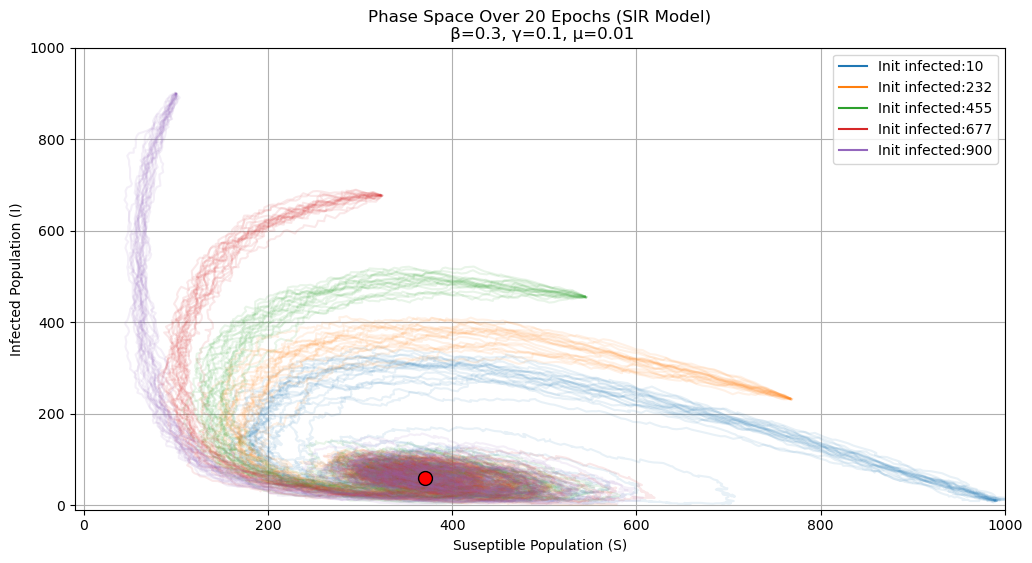

CPU times: user 17.5 s, sys: 51 ms, total: 17.6 s
Wall time: 17.5 s


In [21]:
%%time
plot_phase(N, epochs, beta, gamma, mu, 5, t)

-----
## Extinction events and Critical Community Size

In [22]:
def extinction_experiment_R0(epochs, N, R0_values, gamma, mu, t_max):
    """
    Run multiple Gillespie simulations to determine the probability of extinction for various R0.

    Parameters:
    ----------
    epochs: integer
        The number of simulations to run for each R0 value.
    N: int
        The population size.
    R0_values: list 
        A list or array of R0 values to test. R0 is varied by adjusting the transmission rate (beta),
        while keeping the recovery rate (gamma) fixed.
    gamma: float
        The recovery rate.
    mu: float
        The death rate.
    t_max: integer
        The maximum simulation time for each run.

    Returns:
    -------
    extinction_probabilities : list
        A list of extinction probabilities for each R0 value. Each entry represents the proportion of 
        epochs in which extinction occurred (i.e., the infected population reached zero) for a specific R0.
    """
    
    extinction_probabilities = []
    
    for R0 in R0_values:
        beta = R0 * gamma 
        extinctions = []
        for _ in range(epochs):
            S = N - 1
            I = 1
            results, t_list, extinction_event = gillespie(N, S, I, beta, gamma, mu, t_max)
            extinctions.append(extinction_event)
        
        extinction_probabilities.append(sum(extinctions) / epochs)
    return extinction_probabilities

def extinction_experiment_R0_and_N(epochs, N_values, R0_values, gamma, mu, t_max):
    """
    Run multiple Gillespie simulations to determine the probability of extinction
    for varying values of R0 and population sizes (N).

    Parameters:
    ----------
    epochs : int
        Number of simulations to run for each R0 and N combination.
    N_values : list
        List of population sizes to test.
    R0_values : list
        List of R0 values to test.
    gamma : float
        Recovery rate.
    mu : float
        Death rate.
    t_max : int
        Maximum simulation time.

    Returns:
    -------
    extinction_probabilities : 2D list
        2D list containing extinction probabilities for each R0 and N combination.
    """
    extinction_probabilities = np.zeros((len(R0_values), len(N_values)))  # Create a 2D array

    for i, R0 in enumerate(R0_values):
        beta = R0 * (gamma + mu)  # Calculate beta based on desired R0
        for j, N in enumerate(N_values):
            extinctions = []
            for _ in range(epochs):
                S = N - 1
                I = 1
                results, t_list, extinction_event = gillespie(N, S, I, beta, gamma, mu, t_max)
                extinctions.append(extinction_event)
                
            extinction_probabilities[i, j] = sum(extinctions) / epochs  # Store the probability

    return extinction_probabilities


In [23]:
epochs = 10
N = 500 
N_values = np.linspace(100, 1000, 10).astype(int) 
R0_values = np.linspace(1.0, 10.0, 50)
gamma = 0.1
mu = 0.01
t_max = 365 

/tmp/ipykernel_32276/4185352313.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


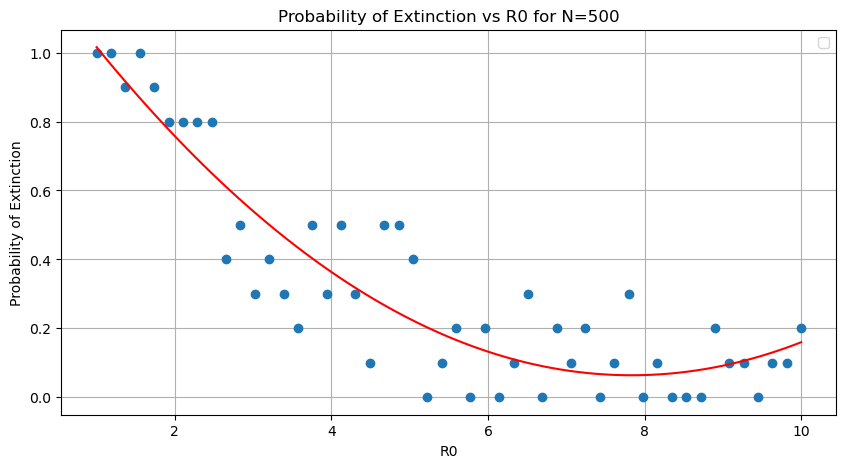

In [24]:
extinction_probabilities = extinction_experiment_R0(epochs, N, R0_values, gamma, mu, t_max)

plt.figure(figsize=(10, 5))
plt.plot(R0_values, extinction_probabilities, 'o')

coeffs = np.polyfit(R0_values, extinction_probabilities, 2) 
poly_fit = np.poly1d(coeffs)
R0_smooth = np.linspace(min(R0_values), max(R0_values), 100)
plt.plot(R0_smooth, poly_fit(R0_smooth), 'r-')

plt.xlabel("R0")
plt.ylabel("Probability of Extinction")
plt.title("Probability of Extinction vs R0 for N=500")
plt.grid()
plt.legend()
plt.show()

In [25]:
R0_values = np.linspace(1.0, 5.0, 50)

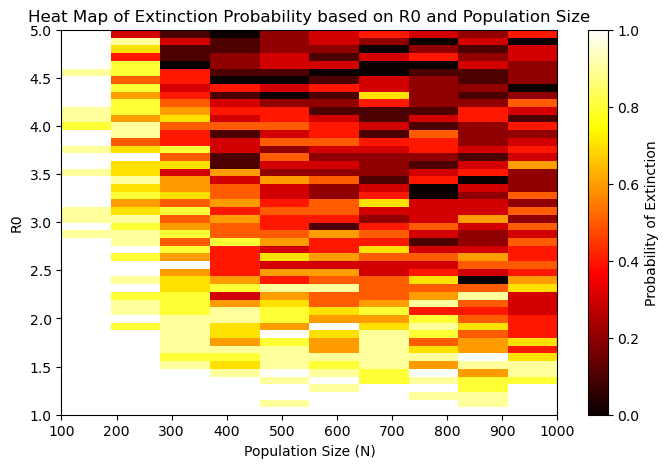

In [26]:
extinction_probabilities_R0_and_N = extinction_experiment_R0_and_N(epochs, N_values, R0_values, gamma, mu, t_max)

plt.figure(figsize=(8, 5))
plt.imshow(extinction_probabilities_R0_and_N, aspect='auto', cmap='hot', origin='lower', 
           extent=[N_values[0], N_values[-1], R0_values[0], R0_values[-1]])
plt.colorbar(label='Probability of Extinction')
plt.xlabel("Population Size (N)")
plt.ylabel("R0")
plt.title("Heat Map of Extinction Probability based on R0 and Population Size")
plt.show() 

-----
# Problem 2: Spatial Models - Networks

In [6]:
class Network():
    """
    Represents a network structure used to model disease transmission.

    Parameters:
    ----------
    network_type : str, optional
        The type of network to generate ('erdos_renyi', 'barabasi_albert', or 'watts_strogatz').
    N : int, optional
        The number of nodes in the network.
    connection_prob : float, optional
        The probability of connections between nodes for Erdős-Rényi and Watts-Strogatz networks.
    avg_degree : int, optional
        The average degree for Barabási-Albert and Watts-Strogatz networks.
    """

    def __init__(self, network_type=None, N=None, connection_prob=None, avg_degree=None, clustering_coeff=None):
        self.network = self.generate_network(
            network_type, N, connection_prob, avg_degree, clustering_coeff)
        attr = {n: {"Tested": False, "Vaccinated": "False"}
                for n in self.network.nodes()}
        self.network_type = network_type
        self.network.remove_nodes_from(list(nx.isolates(self.network)))
        nx.set_node_attributes(self.network, attr)

    def init_data(self):
        """
        Initializes data from a CSV file for creating a network.

        Returns:
        -------
        pandas.DataFrame
            A DataFrame representing the adjacency matrix for the network.
        """
        data = pd.read_csv("data/transmission_network.csv", sep=";")
        data = data.set_index("Unnamed: 0")
        data.index.name = None
        data.columns = data.columns.astype(int)
        return data

    def generate_network(self, network_type=None, N=None, connection_prob=None, avg_degree=None, clustering_coeff=None):
        """
        Generates a network based on the specified type and parameters.
        If no network type is provided, the network is generated from the provided data.

        Parameters:
        ----------
        network_type : str, optional
            The type of network to generate ('erdos_renyi', 'barabasi_albert', or 'watts_strogatz').
        N : int, optional
            The number of nodes in the network.
        connection_prob : float, optional
            The probability of connections for Erdős-Rényi and Watts-Strogatz networks.
        avg_degree : int, optional
            The average degree for Barabási-Albert and Watts-Strogatz networks.
        clustering_coeff : float, optional
            Desired clustering coefficient for Watts-Strogatz networks.

        Returns:
        -------
        networkx.Graph
            The generated network based on the provided parameters.
        """
        if network_type == 'erdos_renyi':
            if connection_prob is None:
                raise ValueError(
                    "Connection probability is required for Erdős-Rényi network.")
            G = nx.erdos_renyi_graph(N, connection_prob)

        elif network_type == 'barabasi_albert':
            if avg_degree is None or avg_degree < 1:
                raise ValueError(
                    "Average degree must be >= 1 for Barabási-Albert network.")
            m = avg_degree // 2
            G = nx.barabasi_albert_graph(N, m)

        elif network_type == 'watts_strogatz':
            if avg_degree is None or connection_prob is None:
                raise ValueError(
                    "Both average degree and connection probability are required for Watts-Strogatz network.")
            G = nx.watts_strogatz_graph(N, avg_degree, connection_prob)

            if clustering_coeff is not None:
                current_cc = nx.average_clustering(G)
                if not np.isclose(current_cc, clustering_coeff, atol=0.01):
                    print(
                        f"Warning: Desired clustering coefficient not achieved. Current: {current_cc}, Target: {clustering_coeff}")

        elif network_type == None:
            data = self.init_data()
            G = nx.from_pandas_adjacency(data)

        else:
            raise ValueError("Invalid network type.")

        return G

    def create_model(self, beta, gamma, num_infected, infect_hubs_only=False):
        """
        Creates a disease transmission model based on the network.

        Parameters:
        ----------
        beta : float
            Transmission rate between individuals.
        gamma : float
            Recovery rate of infected individuals.
        num_infected : int
            Initial number of infected individuals in the network.
        infect_hubs_only : bool, optional
            If True, only the most connected nodes are infected.

        Returns:
        -------
        gc.CompositeModel
            The model configured for disease transmission and recovery.
        """
        model = gc.CompositeModel(self.network)
        model.add_status("Susceptible")
        model.add_status("Infected")
        model.add_status("Removed")

        c_beta = cpm.NodeStochastic(
            beta, triggering_status="Infected")  # Susceptible - Infected
        c_gamma = cpm.NodeStochastic(gamma)  # Infected - Removed
        c_tested = cpm.NodeCategoricalAttribute(
            "Vaccinated", 'True', probability=1)

        model.add_rule("Susceptible", "Infected", c_beta)
        model.add_rule("Infected", "Removed", c_gamma)
        model.add_rule("Susceptible", "Removed",
                       c_tested)  # TODO change to removed

        config = mc.Configuration()
        frac_infected = num_infected / len(self.network)

        if infect_hubs_only:
            degrees = sorted(self.network.degree, key=lambda x: x[1], reverse=True)
            hubs = [node for node, degree in degrees[:num_infected]]
            non_hubs = [node for node in self.network.nodes if node not in hubs]
            config.add_model_initial_configuration("Infected", hubs)
            config.add_model_initial_configuration("Susceptible", non_hubs)
        else:
            frac_infected = num_infected / len(self.network)
            config.add_model_parameter('fraction_infected', frac_infected)
            
        model.set_initial_status(config)
        return model

    def run_simulation(self, t, beta, gamma, num_infected, infect_hubs_only=False):
        """
        Runs the disease transmission simulation over a specified number of time steps.

        Parameters:
        ----------
        t : int
            Number of time steps for the simulation.
        beta : float
            Transmission rate.
        gamma : float
            Recovery rate.
        num_infected : int
            Initial number of infected individuals.
        infect_hubs_only : bool, optional
            If True, only the most connected nodes are infected.

        Returns:
        -------
        tuple
            A tuple containing the final counts of Susceptible (S), Infected (I),
            Removed (R) individuals, and the number of vaccinated individuals.
            Format: (S, I, R, vacc_count)
        """
        if beta < 0 or gamma < 0:
            raise ValueError("Transmission and recovery rates must be >= 0.")
        if num_infected < 0:
            raise ValueError("Number of infected individuals must be >= 0.")

        history = [None] * t
        model = self.create_model(beta, gamma, num_infected, infect_hubs_only)
        self.vaccinated_network = self.network.copy()

        for t_delta in range(t):
            tested = None
            if t_delta % self.tests_inter == 0:
                tested = self.testing_program()
            if t_delta % self.vacc_inter == 0 and tested is not None:
                self.vaccinate_nodes(tested)

            history[t_delta] = model.iteration()

        trends = model.build_trends(history)
        S = trends[0]['trends']['node_count'][0]
        I = trends[0]['trends']['node_count'][1]
        R = trends[0]['trends']['node_count'][2]
        vacc_count = self.vacc_count

        return S, I, R, vacc_count

    def vaccination_setup(self, vacc_total, vacc_num, vacc_inter, tests_total, tests_num, tests_inter, test_accuracy, strategy):
        """
        Sets up the vaccination and testing strategies for the simulation.
        If no vaccinations are allowed, no strategy is applied.

        Parameters:
        ----------
        vacc_total : int
            Total number of vaccinations allowed.
        vacc_num : int
            Number of individuals vaccinated per round.
        vacc_inter : int
            Interval between vaccination rounds.
        tests_total : int
            Total number of tests allowed.
        tests_num : int
            Number of individuals tested per round.
        tests_inter : int
            Interval between testing rounds.
        test_accuracy : float
            Accuracy of the testing method (0 to 1).
        strategy : str
            The vaccination strategy (e.g., 'random', 'degree', 'betweenness', 'closeness').
        """
        if vacc_total < 0 or vacc_num < 0 or vacc_inter < 0:
            raise ValueError("Vaccination parameters must be >= 0.")
        if tests_total < 0 or tests_num < 0 or tests_inter < 0:
            raise ValueError("Testing parameters must be >= 0.")
        if strategy not in ['random', 'degree', 'betweenness', 'closeness']:
            raise ValueError(
                "Invalid vaccination strategy. Choose from 'random', 'degree', 'betweenness', 'closeness'.")

        self.strategy = strategy
        self.vacc_total = vacc_total
        self.vacc_num = vacc_num
        self.vacc_inter = vacc_inter
        self.tests_total = tests_total
        self.tests_num = tests_num
        self.tests_inter = tests_inter
        self.test_accuracy = test_accuracy

        self.vacc_count = 0

    def test_nodes(self, nodes):
        """
        Helper function for testing_program().
        Tests a subset of nodes in the network.

        Parameters:
        ----------
        nodes : list
            List of nodes to be tested for infection.
        """
        for node in nodes:
            if random.random() < self.test_accuracy:
                self.network.nodes[node]['Tested'] = True

    def vaccinate_nodes(self, nodes):
        """
        Helper function for run_simulation().
        Vaccinates a subset of nodes based on the current strategy and testing results.

        Parameters:
        ----------
        nodes : list
            List of nodes to be vaccinated.
        """
        if self.vacc_count >= self.vacc_total:
            return

        vaccinated = nodes[:self.vacc_num]
        for node in vaccinated:
            if self.network.nodes[node]['Tested'] == True:
                self.network.nodes[node]['Vaccinated'] = 'True'
                self.vacc_count += 1

    def test_pool(self, nodes, tests_num):
        """
        Selects nodes for testing based on the current strategy.

        Parameters:
        ----------
        nodes : list
            List of available nodes for testing.
        tests_num : int
            Number of nodes to test.

        Returns:
        -------
        list
            A list of nodes selected for testing.
        """
        if self.strategy == 'random':
            tested = random.sample(nodes, tests_num)

        elif self.strategy == 'degree':
            degrees = dict(self.network.degree(nodes))
            tested = sorted(degrees, key=degrees.get, reverse=True)[:tests_num]

        elif self.strategy == 'closeness':
            closeness = nx.closeness_centrality(self.vaccinated_network)
            tested = sorted(closeness, key=closeness.get,
                            reverse=True)[:tests_num]

        elif self.strategy == 'betweenness':
            betweenness = nx.betweenness_centrality(self.vaccinated_network)
            tested = sorted(betweenness, key=betweenness.get,
                            reverse=True)[:tests_num]

        return tested

    def testing_program(self):
        """
        Conducts the testing program and updates the network with the results.

        Returns:
        -------
        list
            A list of nodes that were tested.
        """
        untested_nodes = [n for n, data in self.network.nodes(
            data=True) if not data.get('Tested', True)]

        tests_num = min(self.tests_num, self.tests_total, len(untested_nodes))
        if tests_num == 0:
            return

        tested = self.test_pool(untested_nodes, tests_num)
        self.test_nodes(tested)
        self.tests_total -= tests_num

        self.vaccinated_network.remove_nodes_from(tested)
        return tested

    def get_network_statistics(self):
        """
        Retrieves various statistics about the current network.

        Returns:
        -------
        tuple
            A tuple containing network statistics: number of nodes, betweenness centrality,
            closeness centrality, degree distribution, average degree,
            eigenvector centrality, and clustering coefficient.
            Format: (N, betweenness, closeness, degrees, average_degree, eigenvalues, clustering)
        """
        N = len(self.network)
        betweenness = nx.betweenness_centrality(self.network)
        closeness = nx.closeness_centrality(self.network)
        degrees = dict(self.network.degree())
        average_degree = np.mean(list(degrees.values()))
        clustering = nx.clustering(self.network)

        return N, betweenness, closeness, degrees, average_degree, clustering

    def plot_network_statistic(self, title=None):
        """
        Plots various centrality and network statistics for the current network.

        Parameters:
        ----------
        title : str optional
            Title of the plot.
        """
        statistics = self.get_network_statistics()
        N = statistics[0]
        betweenness = statistics[1]
        closeness = statistics[2]
        degrees = statistics[3]
        average_degree = statistics[4]
        clustering = statistics[5]

        centralities = pd.DataFrame({
            'Betweenness Centrality': betweenness,
            'Closeness Centrality': closeness,
            'Clustering Coefficient': clustering,
        })

        fig, axs = plt.subplots(1, 3, figsize=(15, 7))
        axs = axs.flatten()

        centrality_names = centralities.columns
        for i, metric in enumerate(centrality_names):
            centrality = centralities[metric].sort_values(ascending=True)
            len_cent = len(centrality)
            axs[i].scatter(centrality.values, np.arange(len_cent), marker='o')
            axs[i].set_yticks([])
            axs[i].set_title(metric)
            axs[i].grid()

            x_min, x_max = axs[i].get_xlim()
            ticks = np.linspace(x_min, x_max, MAX_TICKS)
            axs[i].set_xticks(ticks)
            axs[i].set_xticklabels([f"{tick:.4f}" for tick in ticks])

        if title == None:
            title = ""
        fig.suptitle(title, fontsize=16, y=1)
        plt.show()

    def plot_degree_distribution(self, title=None):
        """
        Plots the degree distribution of the current network in both linear and log-log scale.
        
        Parameters:
        ----------
        title : str optional
            Title of the plot.
        """
        degrees = dict(self.network.degree())
        degree_values = list(degrees.values())
        degree_std = np.std(degree_values)

        unique_degrees, degree_counts = np.unique(
            degree_values, return_counts=True)
        total_nodes = len(degree_values)
        degree_fractions = degree_counts / total_nodes

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        
        axs[0].scatter(unique_degrees, degree_fractions)
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].set_title("Degree Distribution as loglog")
        axs[0].set_xlabel("Degree")
        axs[0].set_ylabel("Fraction of Nodes")
        
        axs[1].bar(unique_degrees, degree_counts, width=0.8)
        axs[1].set_title(f"Degree Distribution (std = {degree_std:.2f})")
        axs[1].set_xlabel("Degree")
        axs[1].set_xlim([min(unique_degrees) - 1, max(unique_degrees) + 1])
        axs[1].set_ylabel("Number of Nodes")

        if title == None:
            title = ""
        fig.suptitle(title, fontsize=16, y=1)
        plt.show()

    def plot_network(self, k=None, weight=None, scale=None):
        """
        Plots the current network with node sizes proportional to degree.

        Parameters:
        ----------
        k : float, optional
            Optimal distance between nodes for layout, affecting the spring layout.
        weight : str, optional
            Edge attribute name for weights, used for scaling node sizes based on degree.
        scale : float, optional
            Scale factor for the layout distance between nodes.
        """
        pos = nx.spring_layout(self.network, k=k, weight=weight, scale=scale)
        degrees = dict(self.network.degree())
        node_sizes = None
        if weight != None:
            node_sizes = [degrees[node] * 10 for node in self.network.nodes()]
        nx.draw(self.network, pos, node_size=node_sizes, width=0.1)

        plt.title(f"{self.network_type} Network")
        plt.show()

In [3]:
def plot_SIR(S, I, R, strategy, title=None):
    """
    Plots the SIR (Susceptible, Infected, Recovered) dynamics for a given strategy.

    Parameters:
    ----------
    S : array-like
        Time series data representing the number of susceptible individuals over time.
    I : array-like
        Time series data representing the number of infected individuals over time.
    R : array-like
        Time series data representing the number of recovered individuals over time.
    strategy : str
        The vaccination or intervention strategy used in the simulation, included in the plot title.
    """
    
    plt.figure()
    plt.plot(S, label="Susceptible", color='blue')
    plt.plot(I, label="Infected", color='red')
    plt.plot(R, label="Recovered", color='green')

    if title == None:
            title = ""
    plt.title(f"SIR Dynamics on a graph {title}")
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.legend()
    plt.grid()
    plt.show()

## Simulate SIR spread on the networks of equivalent form

In [4]:
MAX_TICKS = 5
STEPS = 2 # result will be STEPS * 2 many plots
epochs = 30

N_values = np.linspace(100, 500, STEPS).astype(int) 
connection_probs = np.linspace(0.1, 0.9, STEPS)
average_degrees = np.linspace(7, 14, STEPS).astype(int) 

beta = 0.5
gamma = 0.3
t = 60
num_infected = 10

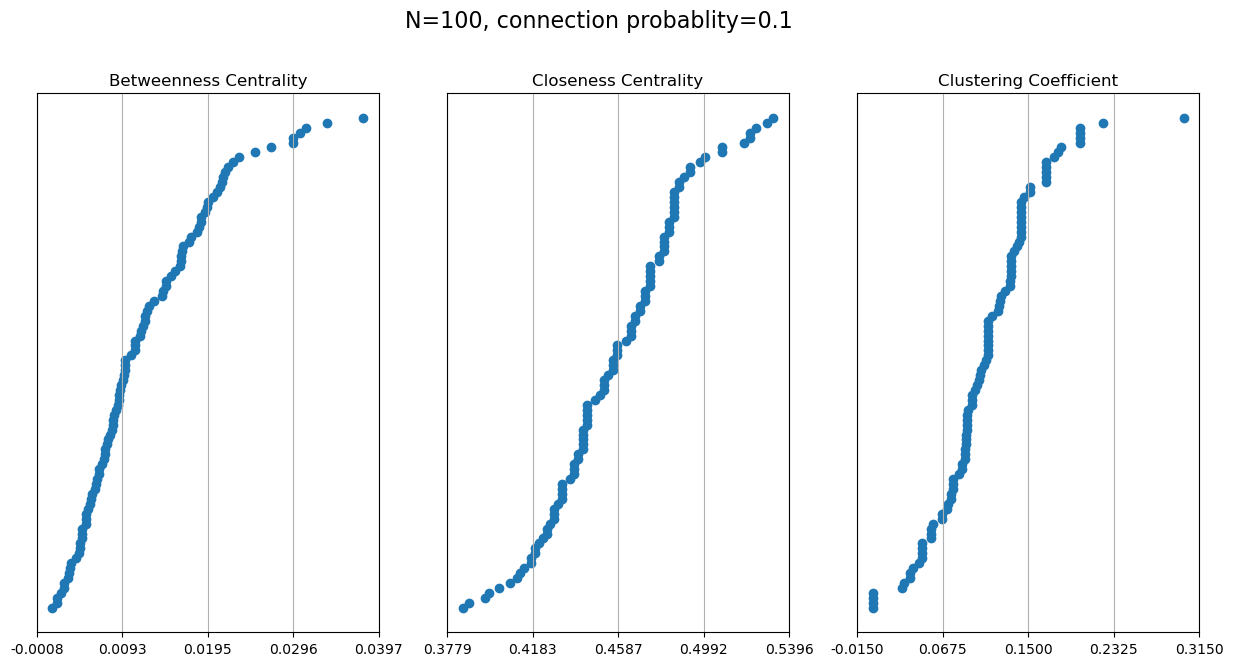

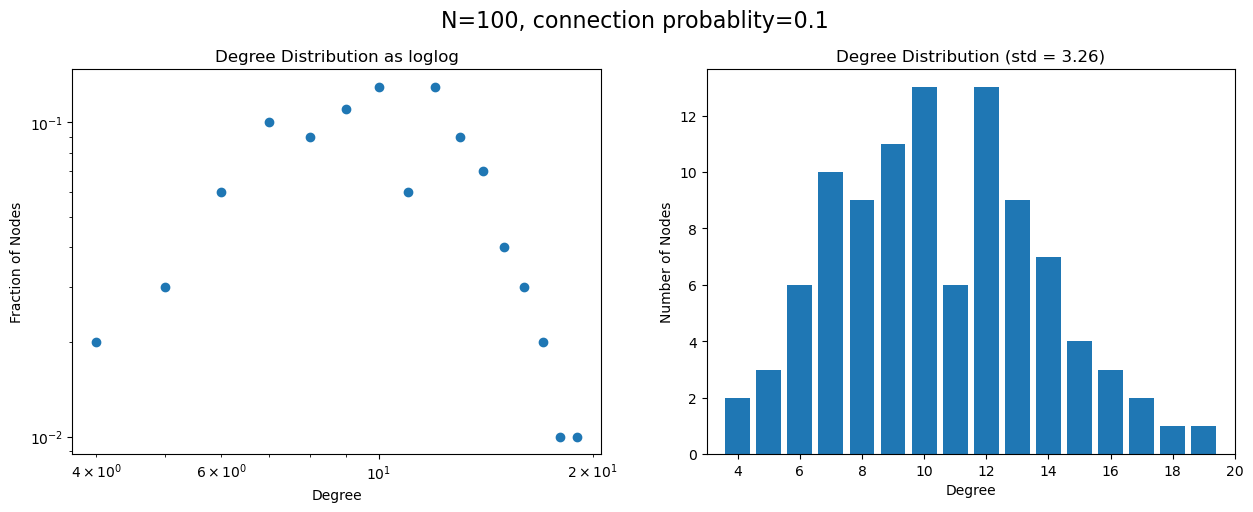

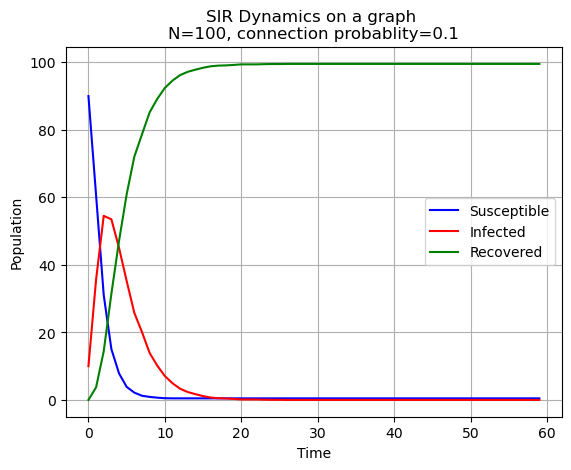

N:100, connection_prob:0.1



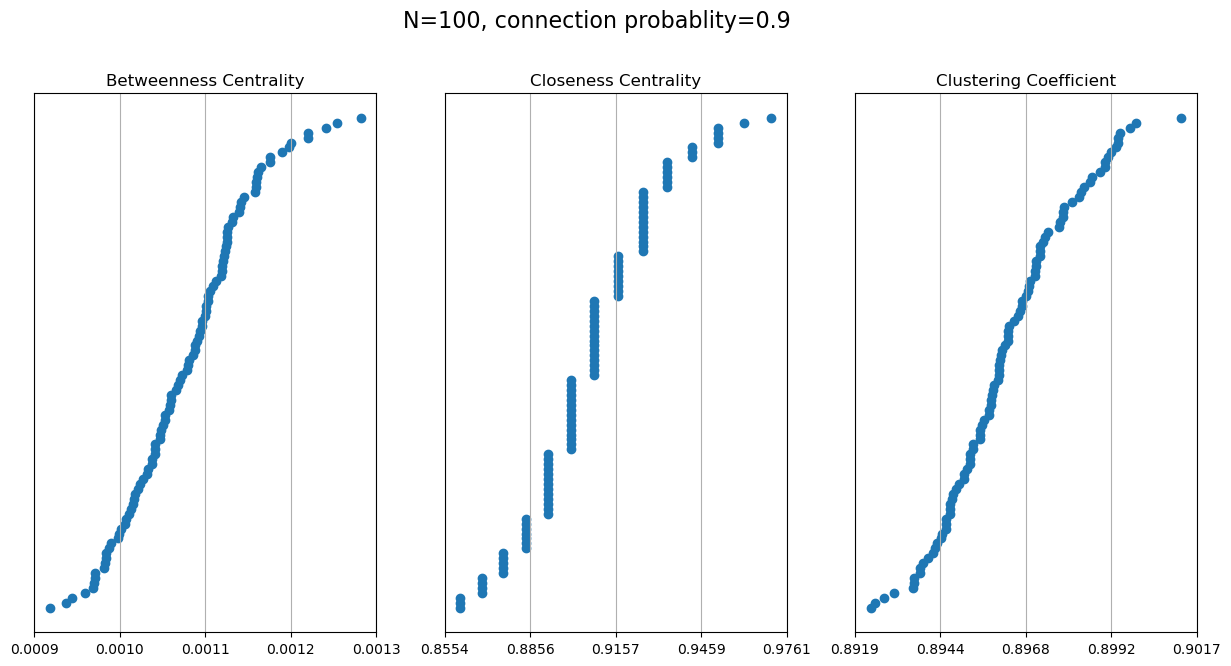

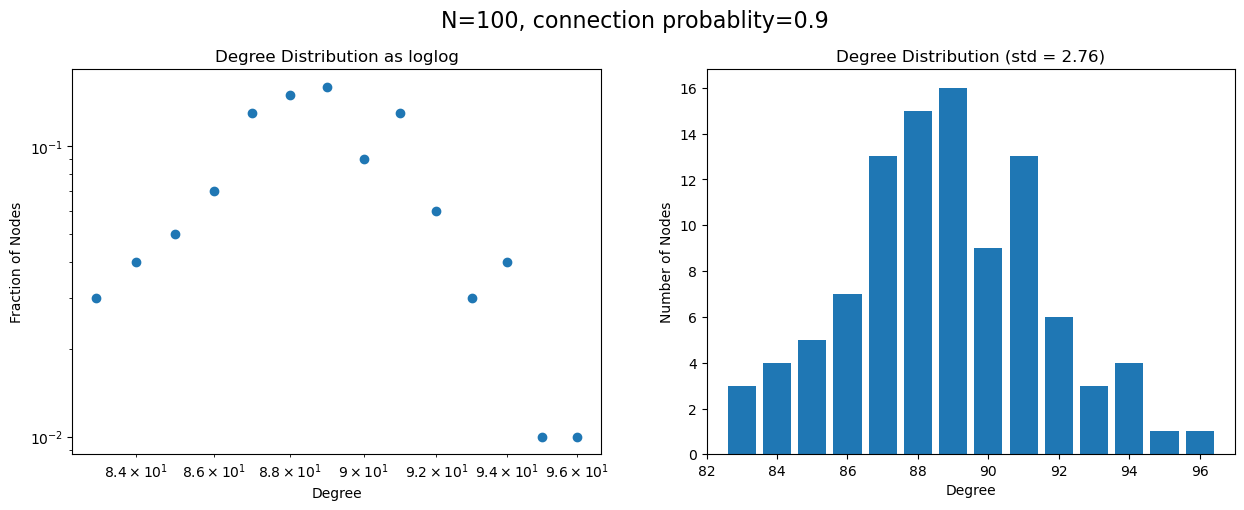

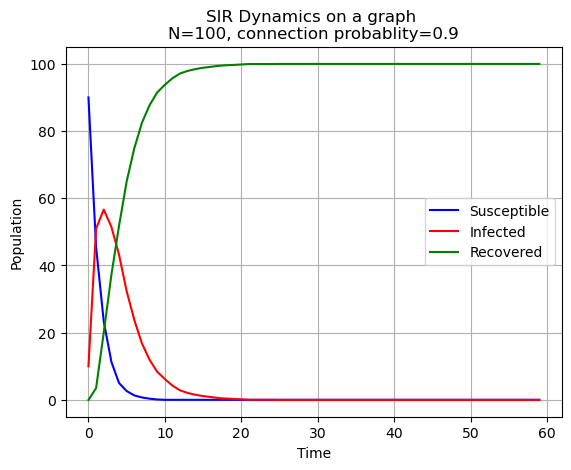

N:100, connection_prob:0.9



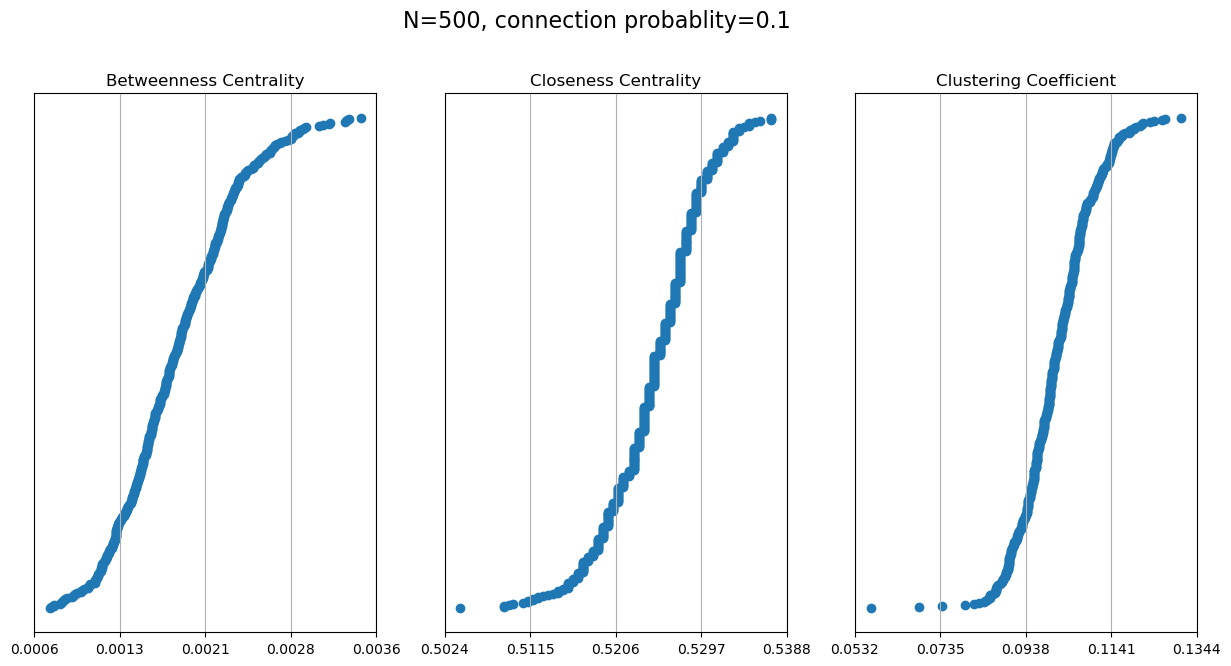

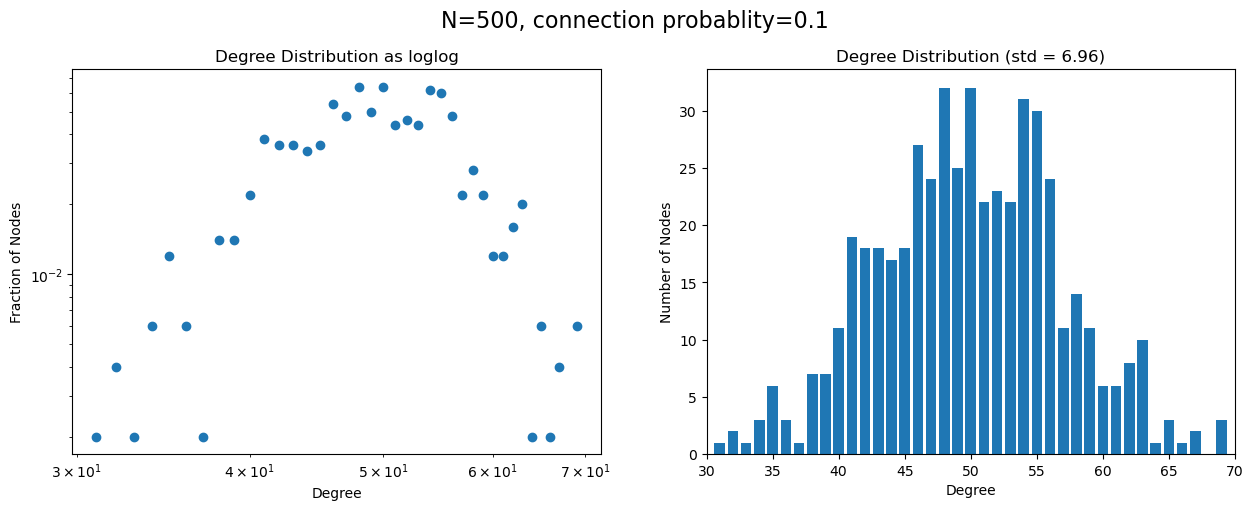

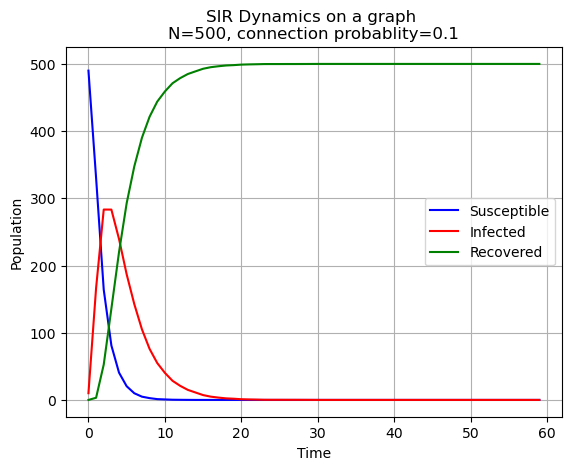

N:500, connection_prob:0.1



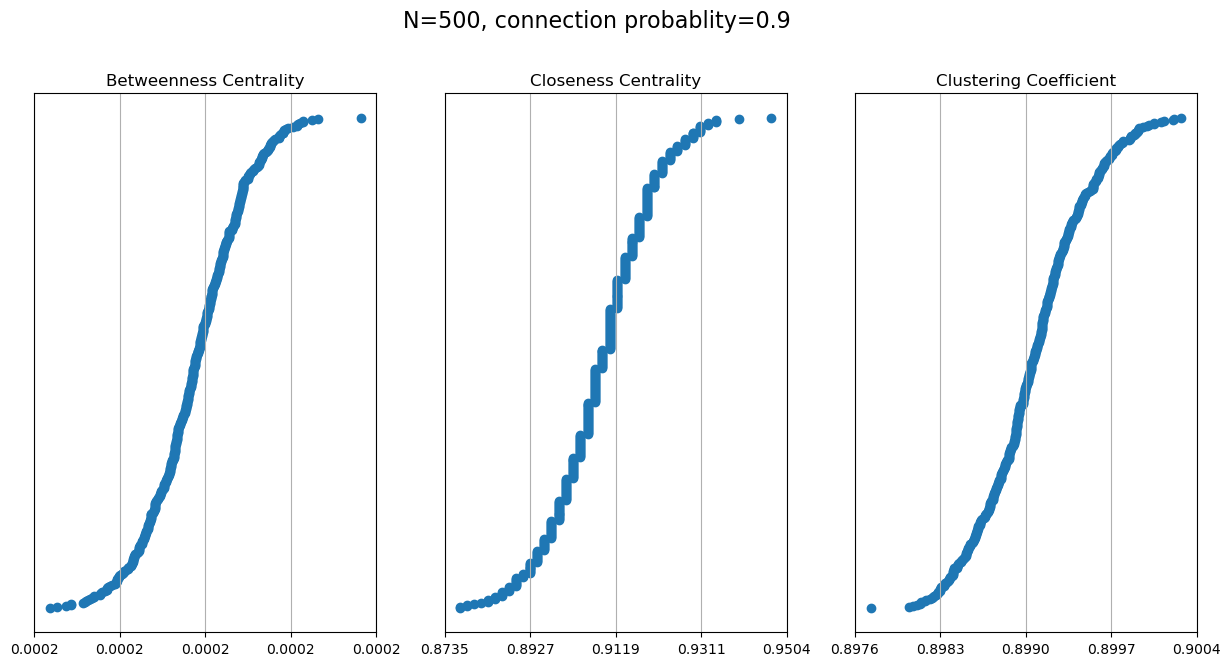

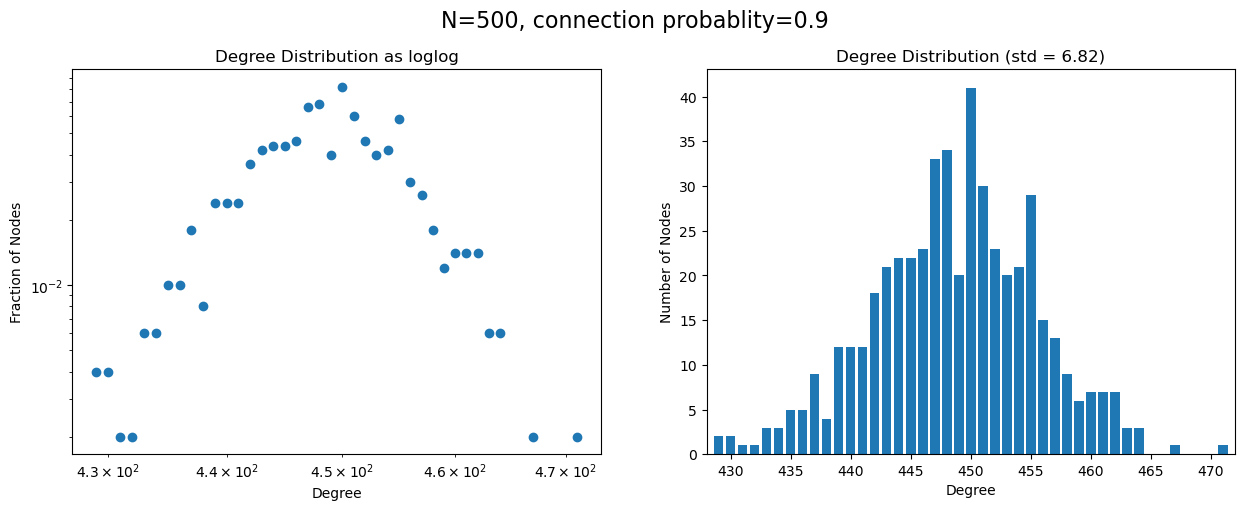

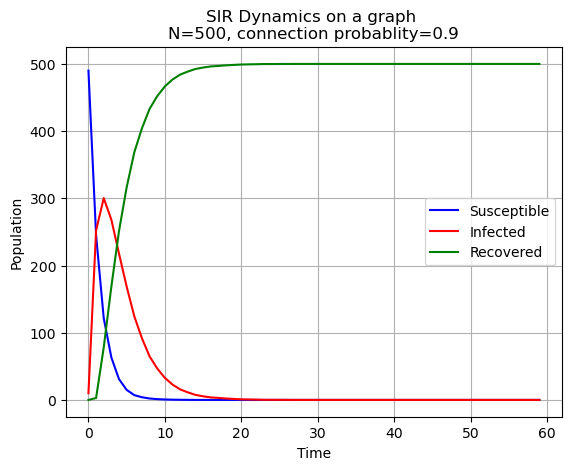

N:500, connection_prob:0.9

CPU times: user 26.4 s, sys: 61 ms, total: 26.4 s
Wall time: 26.4 s


In [30]:
%%time
for N in N_values:
    for prob in connection_probs:
        # allocate memory to create empty lists with a given epoch size 
        history_S = [None] * epochs
        history_I = [None] * epochs
        history_R = [None] * epochs
        history_V = [None] * epochs
        
        erdos_renyi = Network(network_type='erdos_renyi', N=N, connection_prob=prob)
        erdos_renyi.plot_network_statistic(title=f"N={N}, connection probablity={prob}")
        erdos_renyi.plot_degree_distribution(title=f"N={N}, connection probablity={prob}")

        model = erdos_renyi.create_model(beta=beta, gamma=gamma, num_infected=num_infected)
        # values should be 0 otherwise vaccination will be takin into account
        # the strategy doesn't matter because no vaccinations are going to happen
        erdos_renyi.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                      tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
        for _ in range(epochs):
                S, I, R, vacc_count = erdos_renyi.run_simulation(
                    t=t, beta=beta, gamma=gamma, num_infected=num_infected)
                history_S[_] = S
                history_I[_] = I
                history_R[_] = R
            
        plot_SIR(np.mean(history_S, axis=0), np.mean(history_I, axis=0), np.mean(history_R, axis=0), strategy='', title=f"\nN={N}, connection probablity={prob}")
        print(f"N:{N}, connection_prob:{prob}\n")

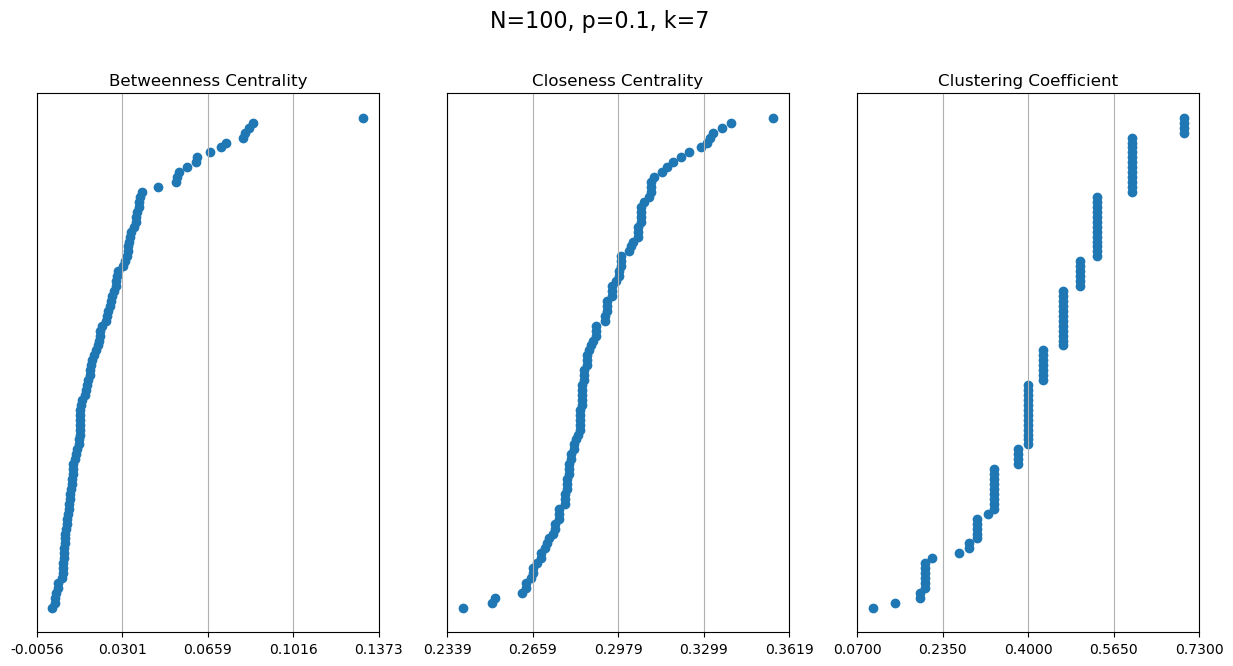

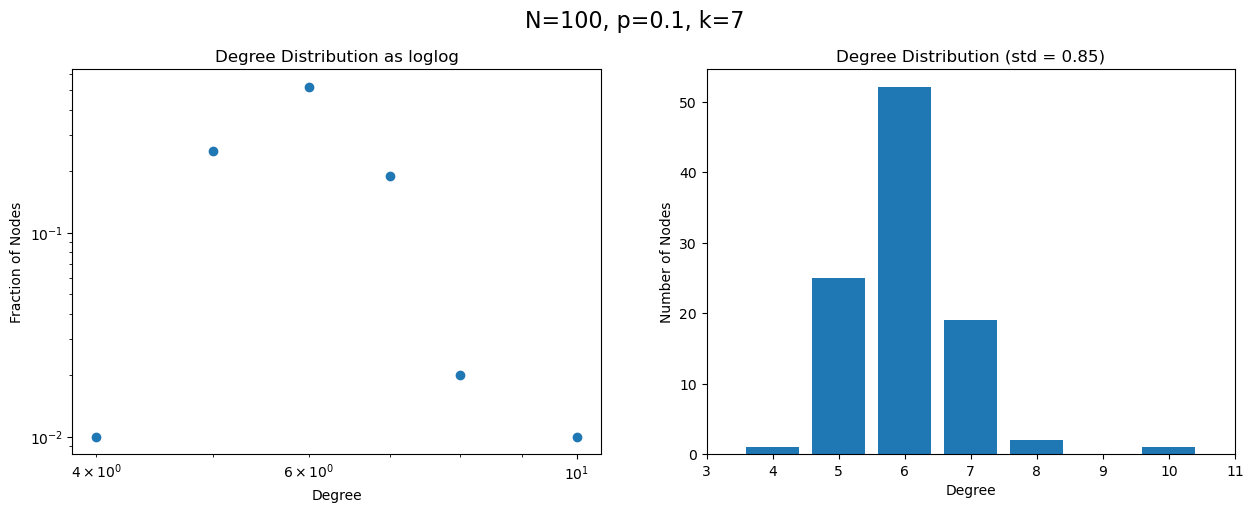

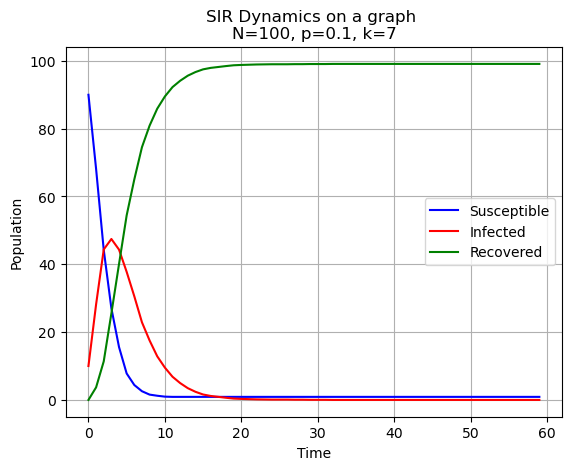

N:100, connection_prob:0.1



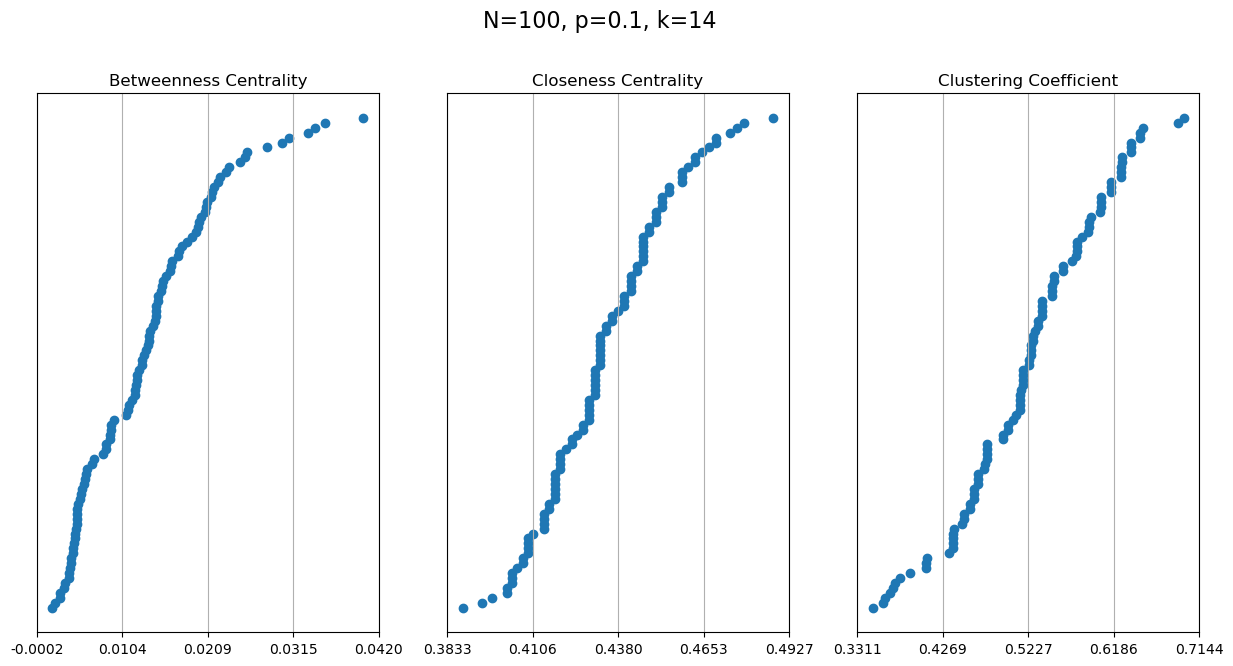

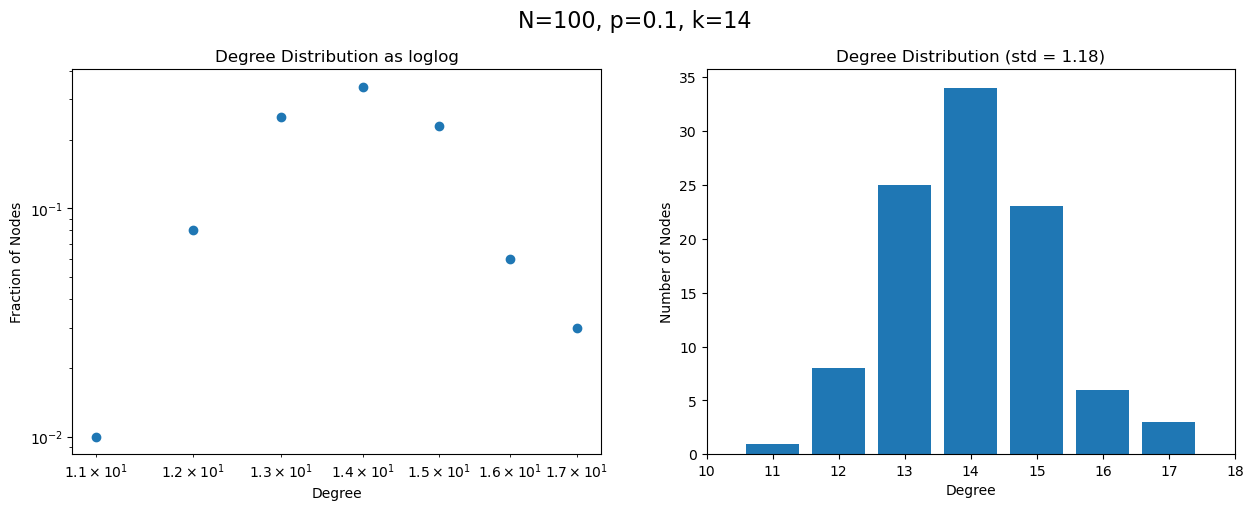

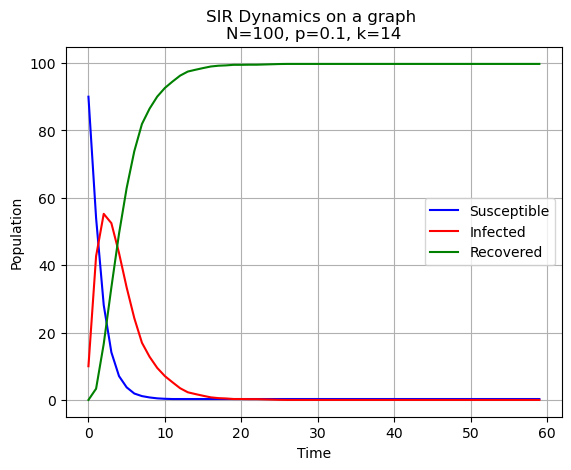

N:100, connection_prob:0.1



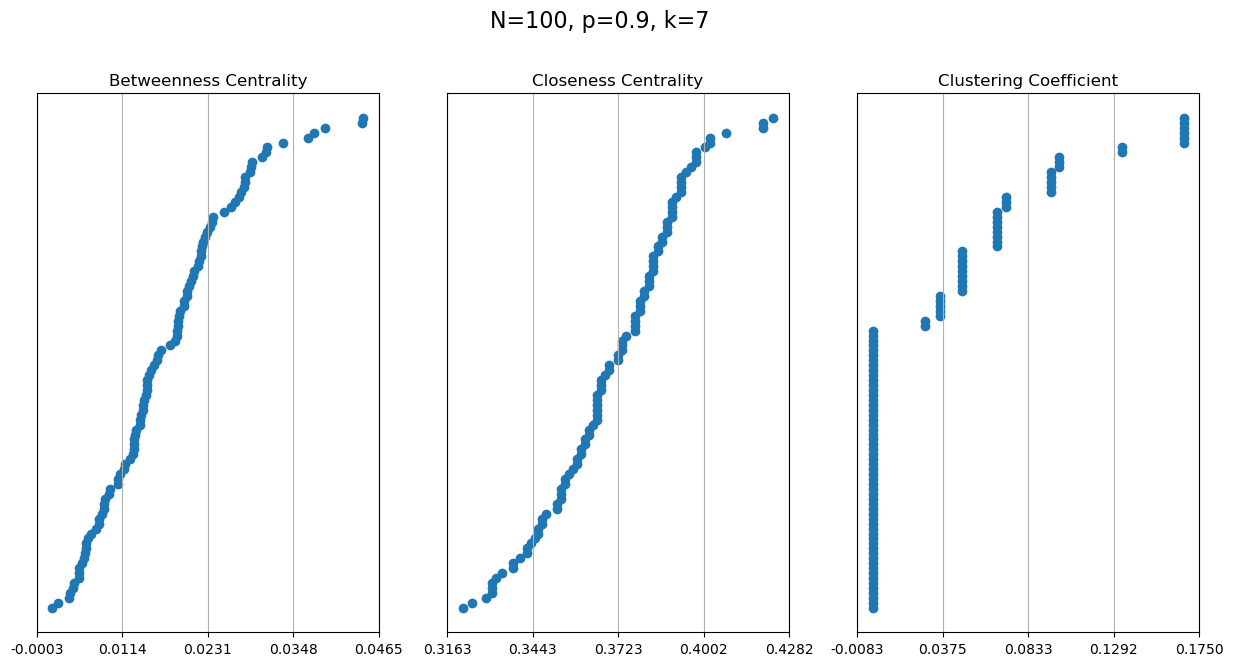

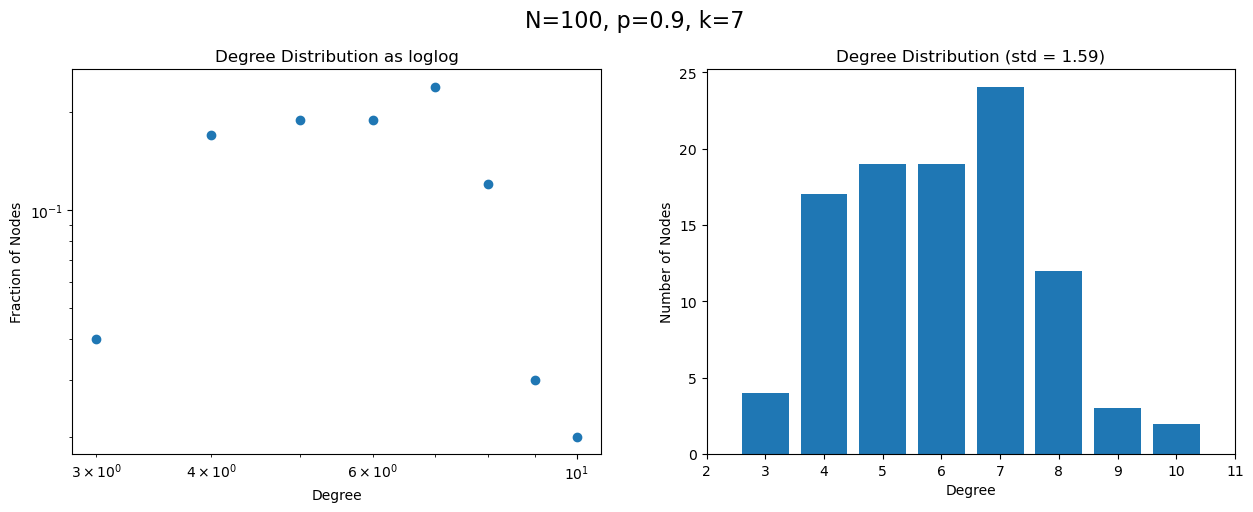

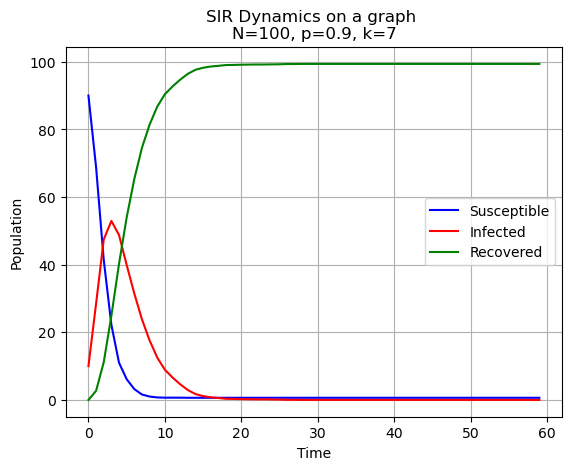

N:100, connection_prob:0.9



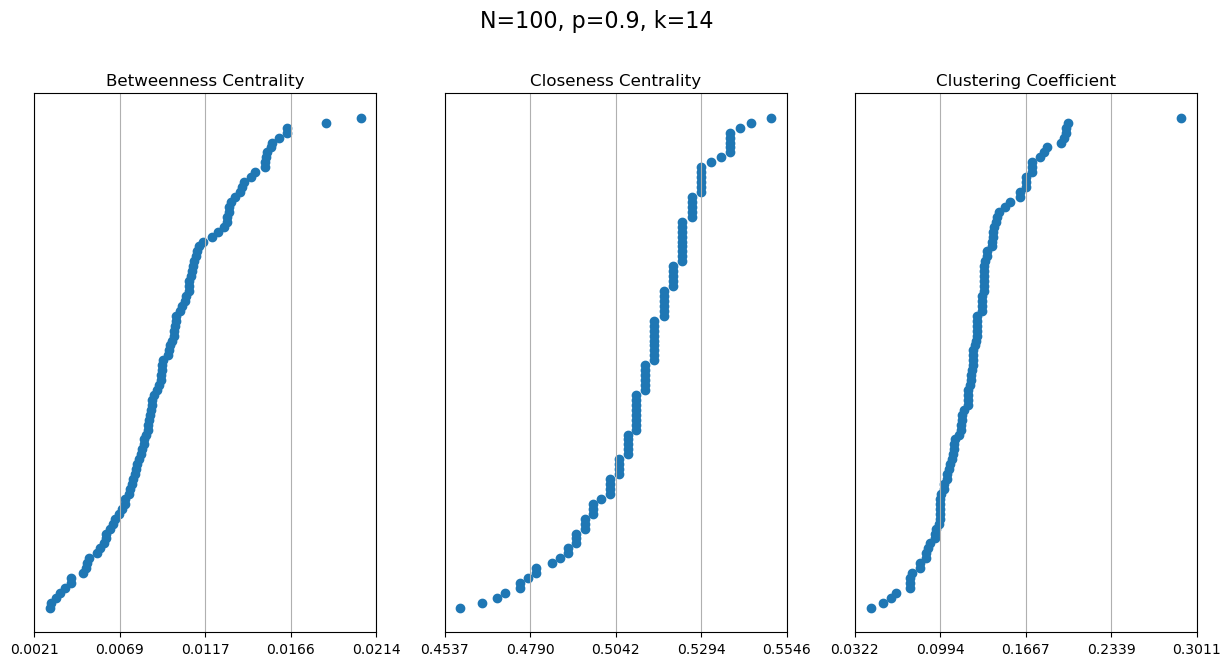

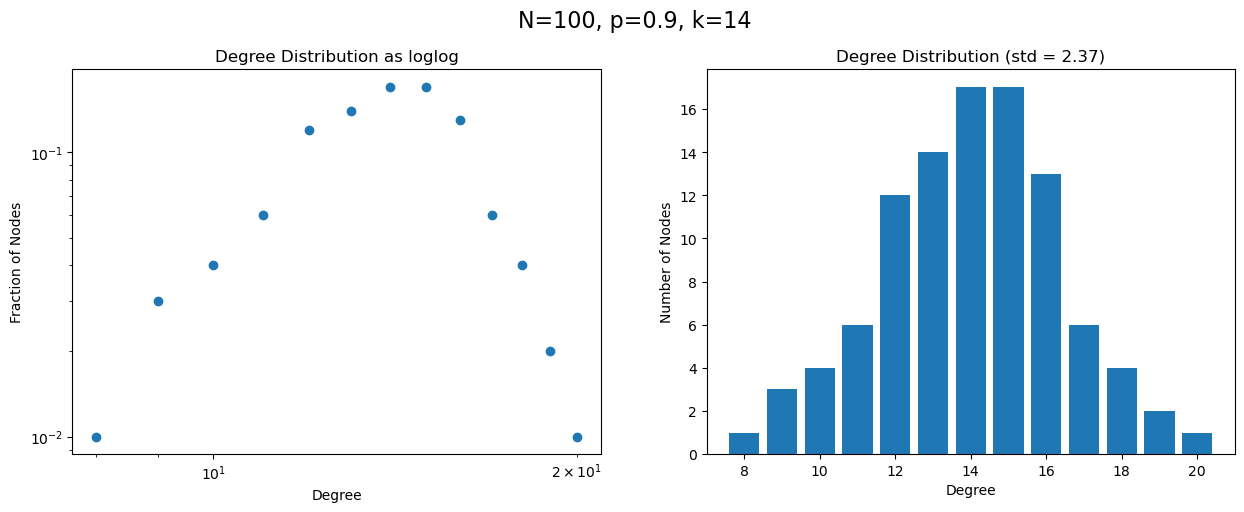

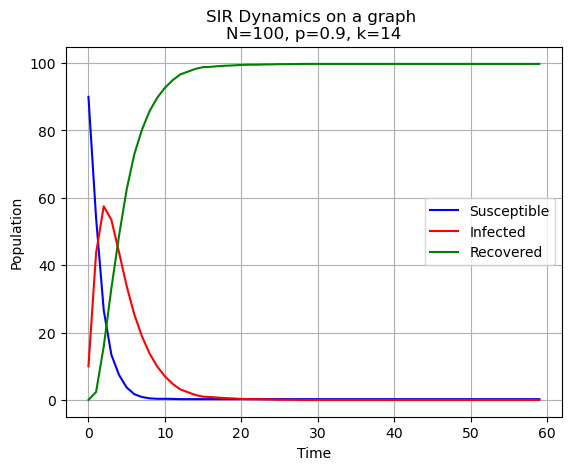

N:100, connection_prob:0.9



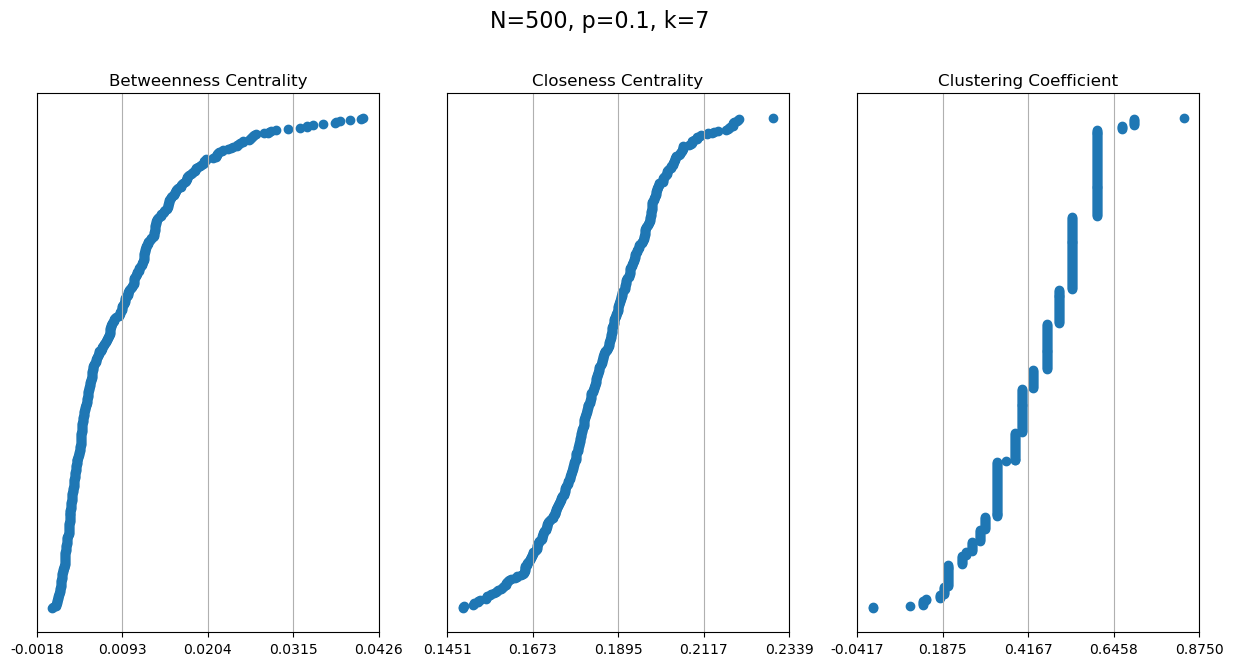

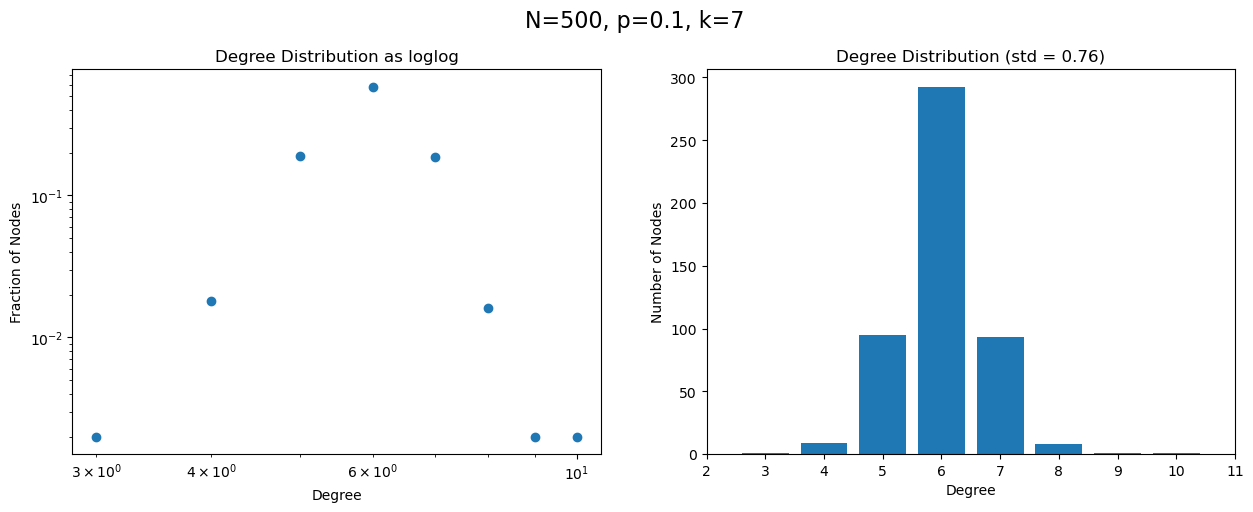

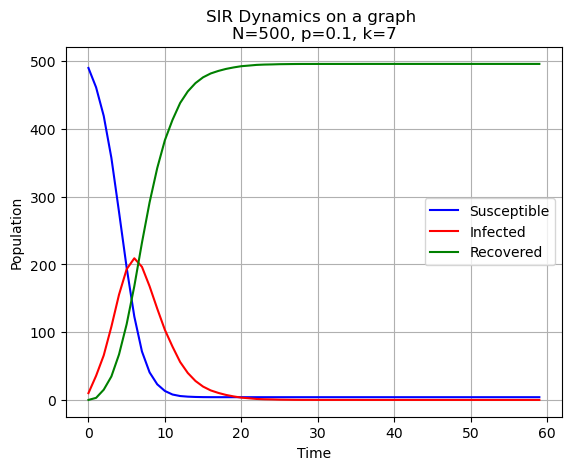

N:500, connection_prob:0.1



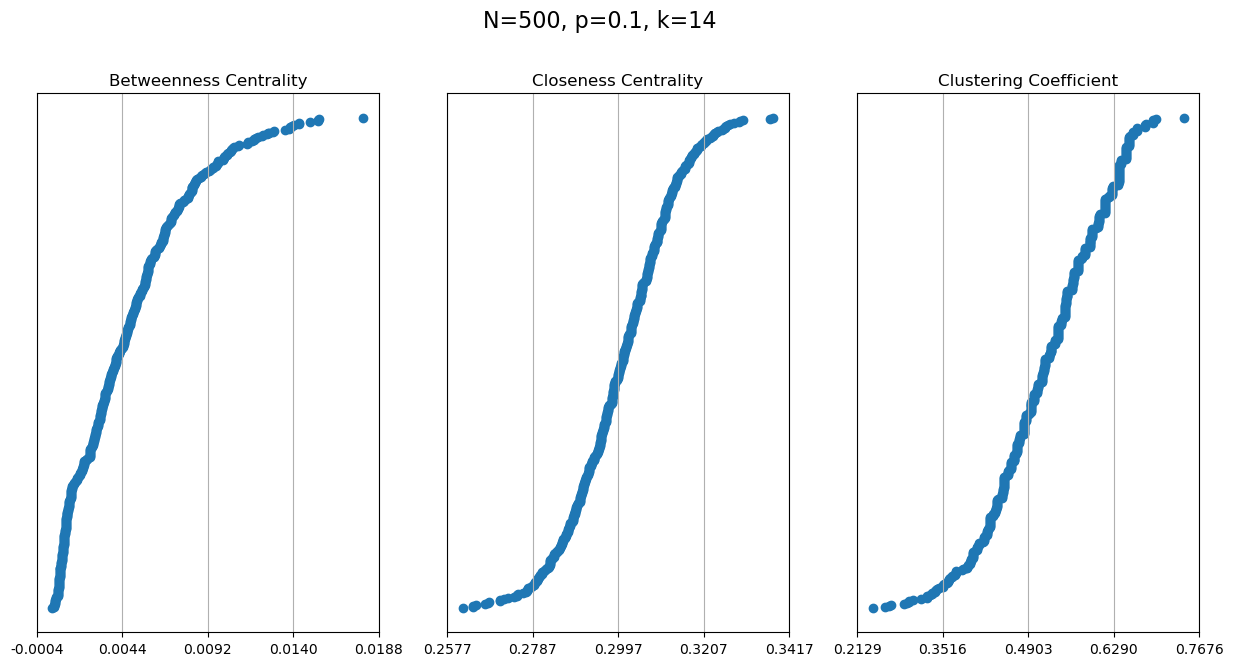

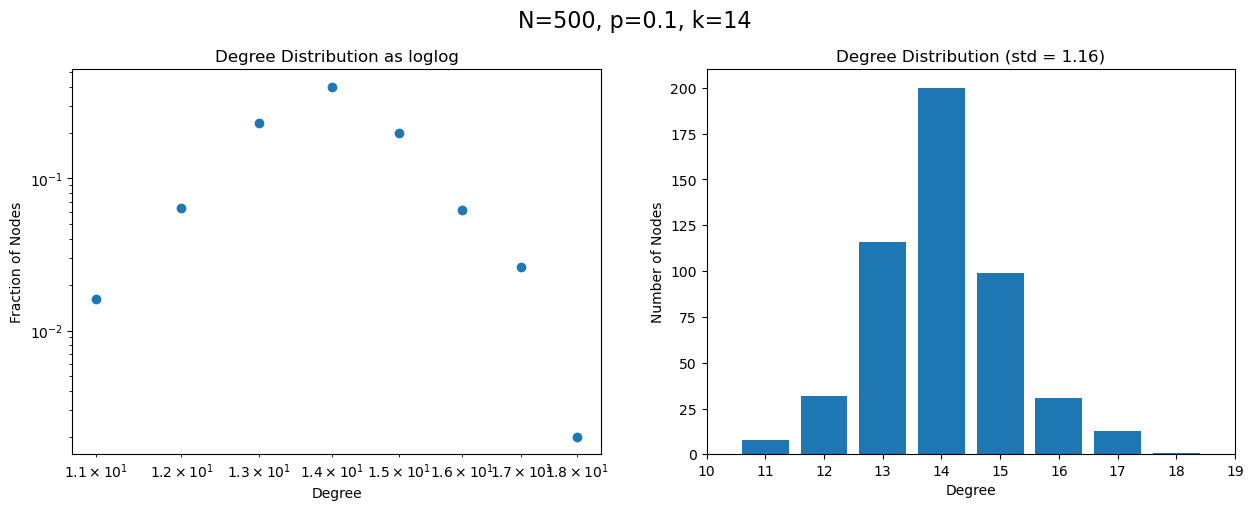

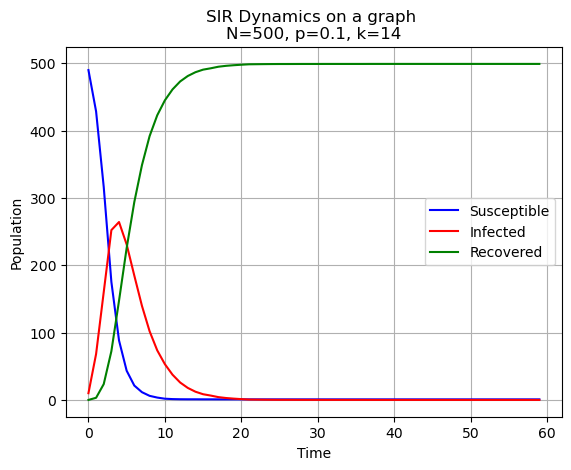

N:500, connection_prob:0.1



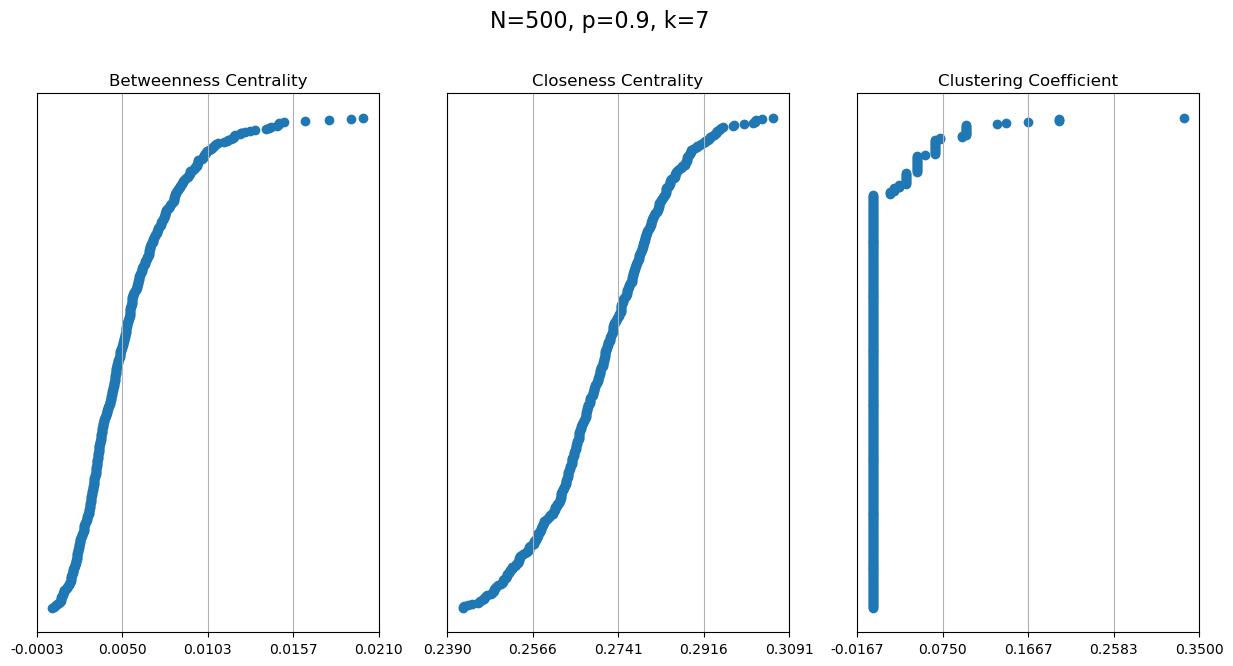

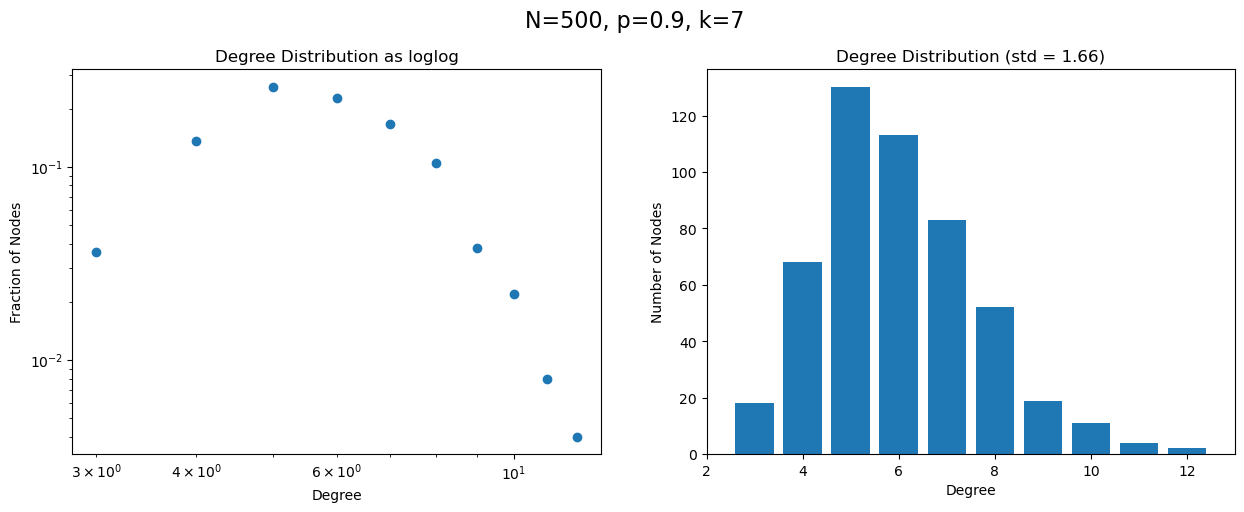

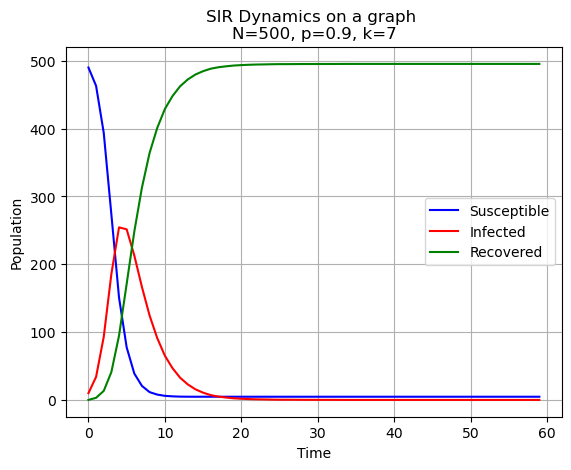

N:500, connection_prob:0.9



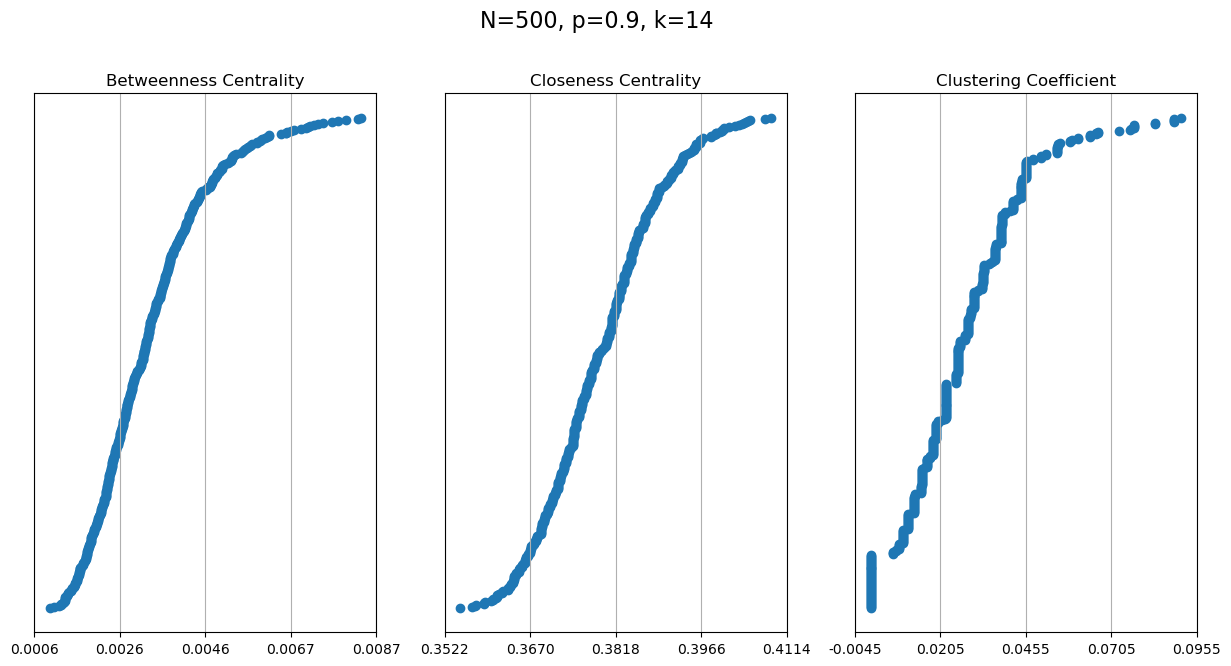

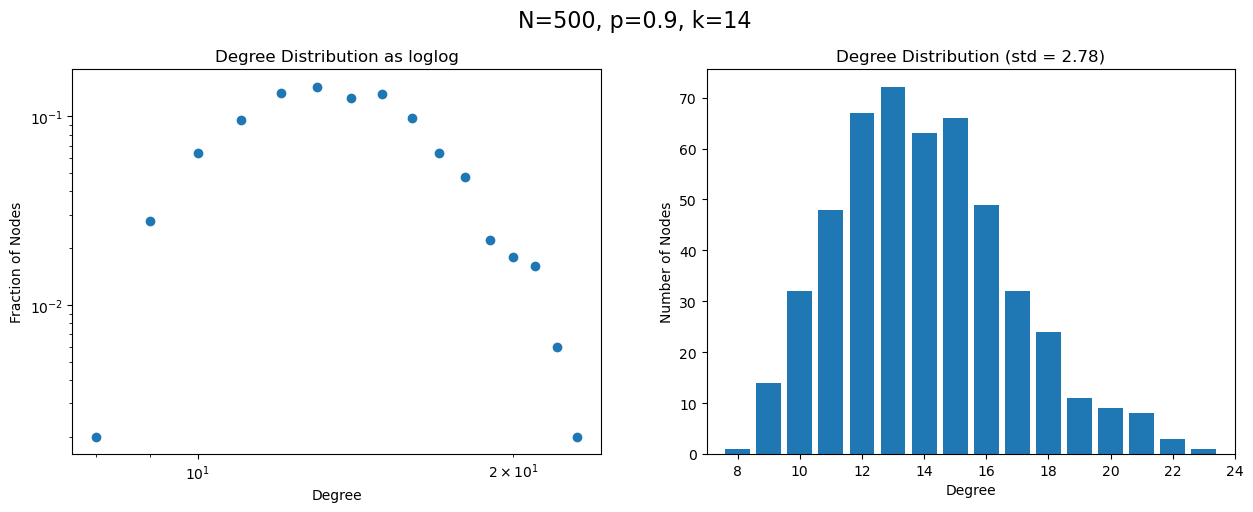

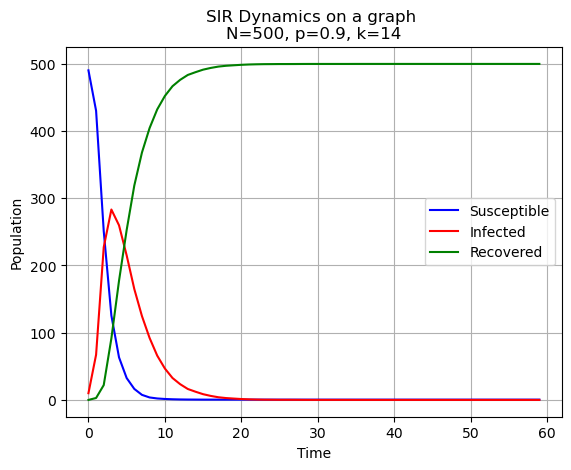

N:500, connection_prob:0.9

CPU times: user 29.8 s, sys: 114 ms, total: 29.9 s
Wall time: 29.9 s


In [12]:
%%time
for N in N_values:
    for prob in connection_probs:
        for avg_degree in average_degrees:
            # allocate memory to create empty lists with a given epoch size 
            history_S = [None] * epochs
            history_I = [None] * epochs
            history_R = [None] * epochs
            history_V = [None] * epochs
            
            watts_strogatz = Network(network_type='watts_strogatz', N=N, connection_prob=prob, avg_degree=avg_degree)
            watts_strogatz.plot_network_statistic(title=f"N={N}, p={prob}, k={avg_degree}")
            watts_strogatz.plot_degree_distribuReporttion(title=f"N={N}, p={prob}, k={avg_degree}")
    
            model = watts_strogatz.create_model(beta=beta, gamma=gamma, num_infected=num_infected)
            # values should be 0 otherwise vaccination will be takin into account
            # the strategy doesn't matter because no vaccinations are going to happen
            watts_strogatz.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                          tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
            for _ in range(epochs):
                    S, I, R, vacc_count = watts_strogatz.run_simulation(
                        t=t, beta=beta, gamma=gamma, num_infected=num_infected)
                    history_S[_] = S
                    history_I[_] = I
                    history_R[_] = R
                
            plot_SIR(np.mean(history_S, axis=0), np.mean(history_I, axis=0), np.mean(history_R, axis=0), strategy='', title=f"\nN={N}, p={prob}, k={avg_degree}")
            print(f"N:{N}, connection_prob:{prob}\n")

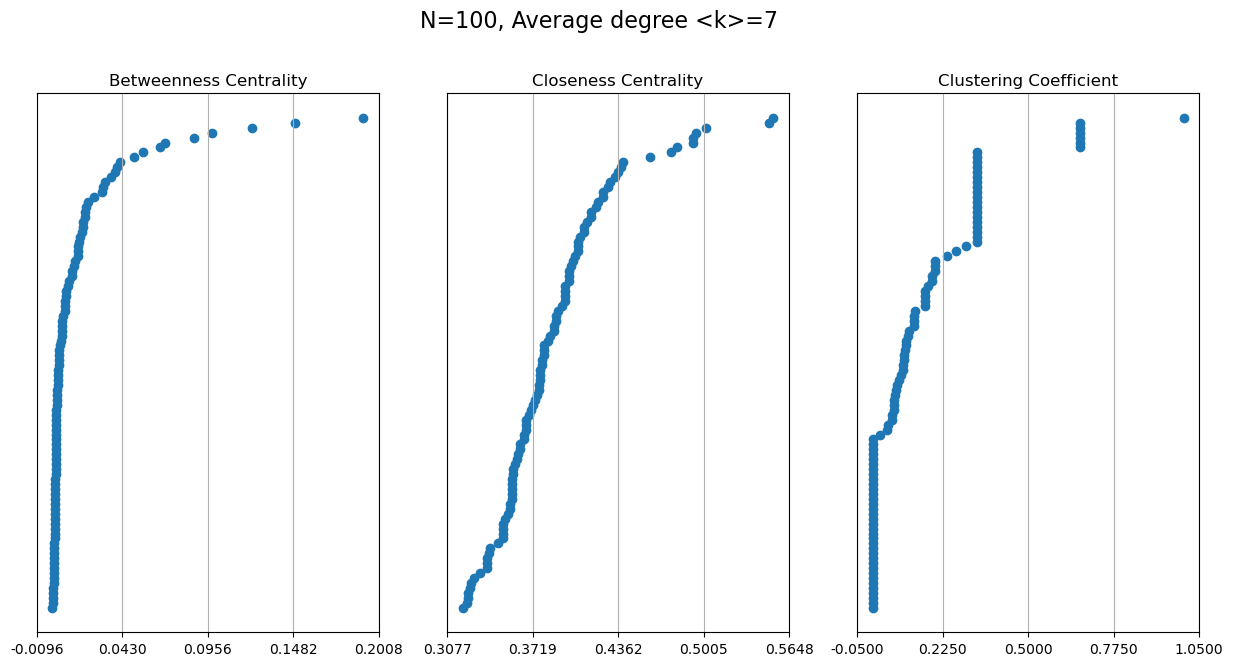

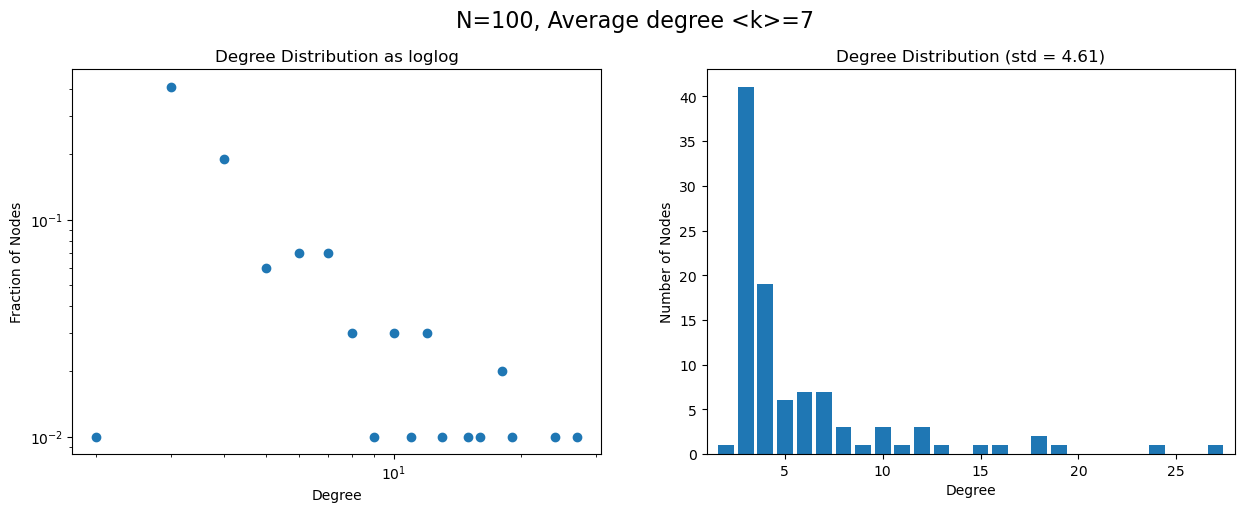

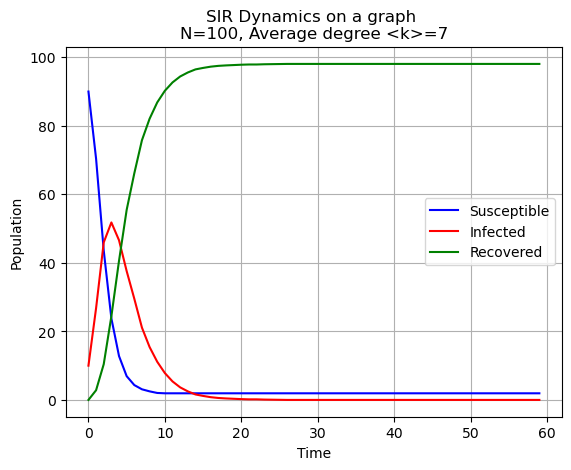

N:100, Average degree <k>=7



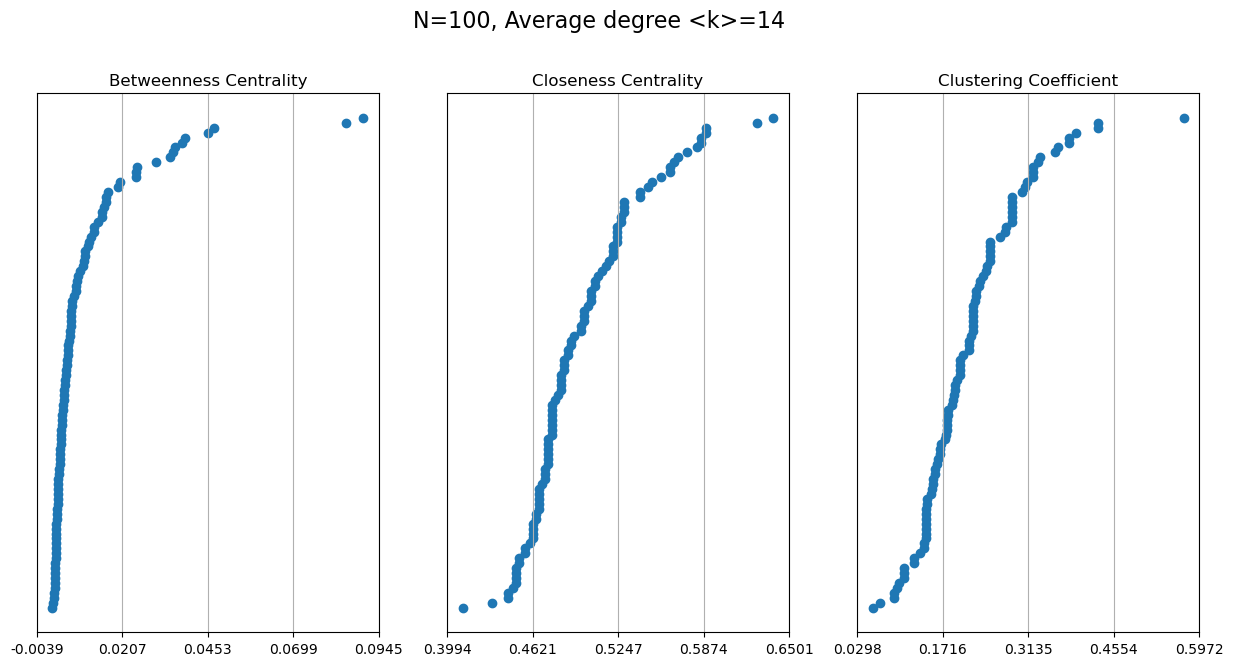

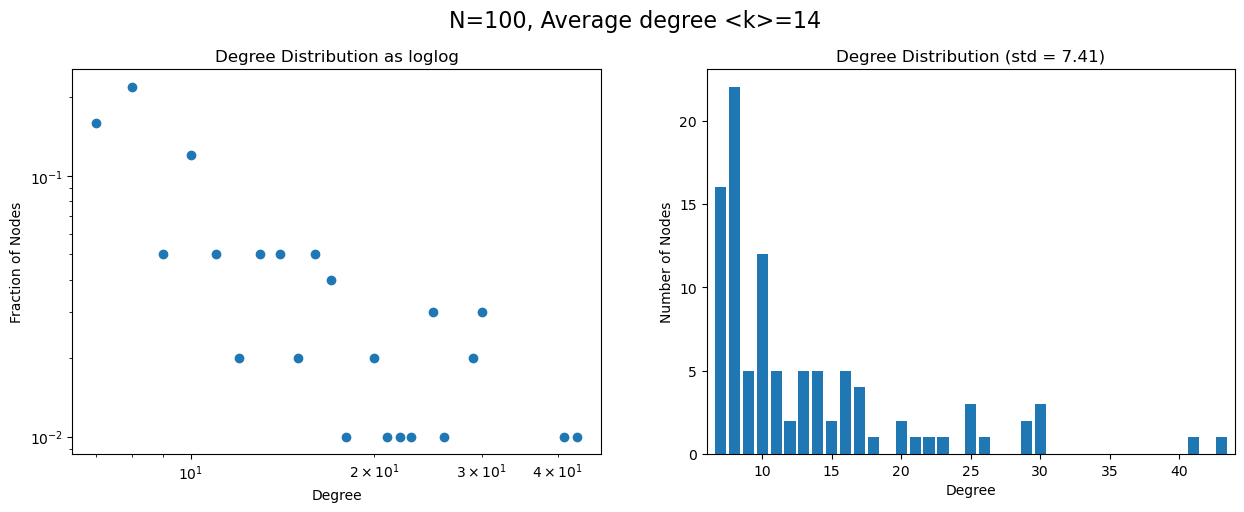

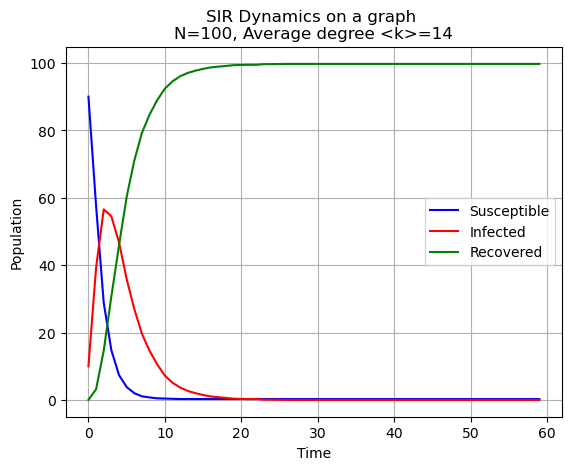

N:100, Average degree <k>=14



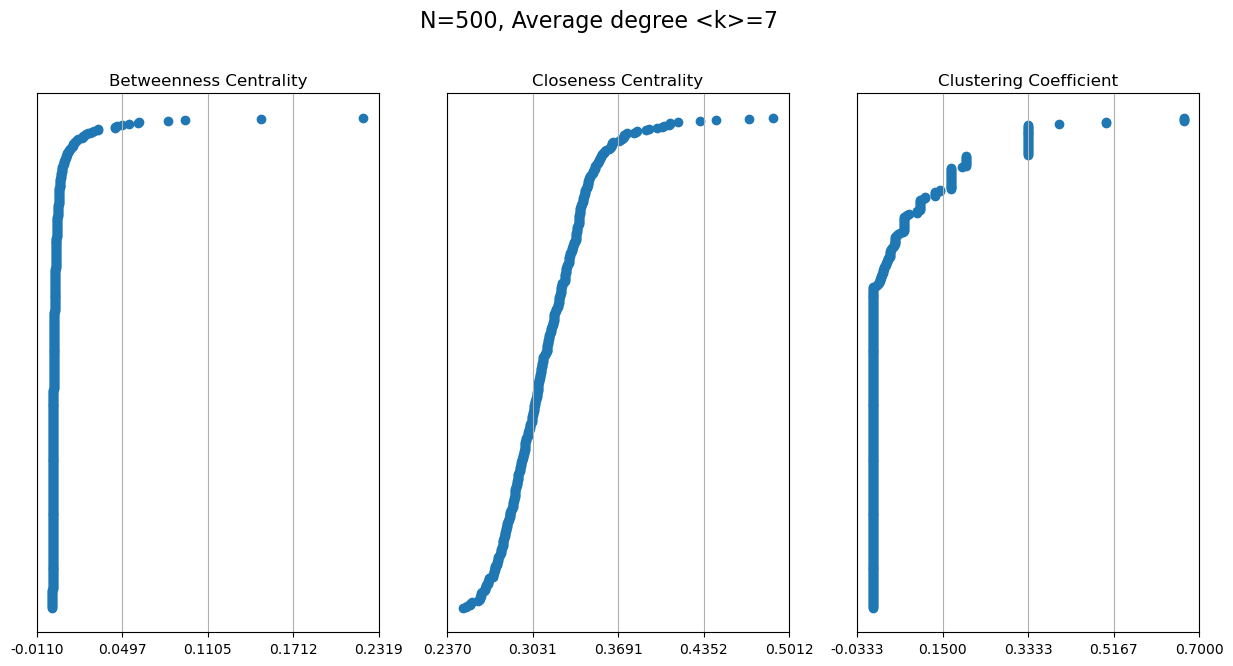

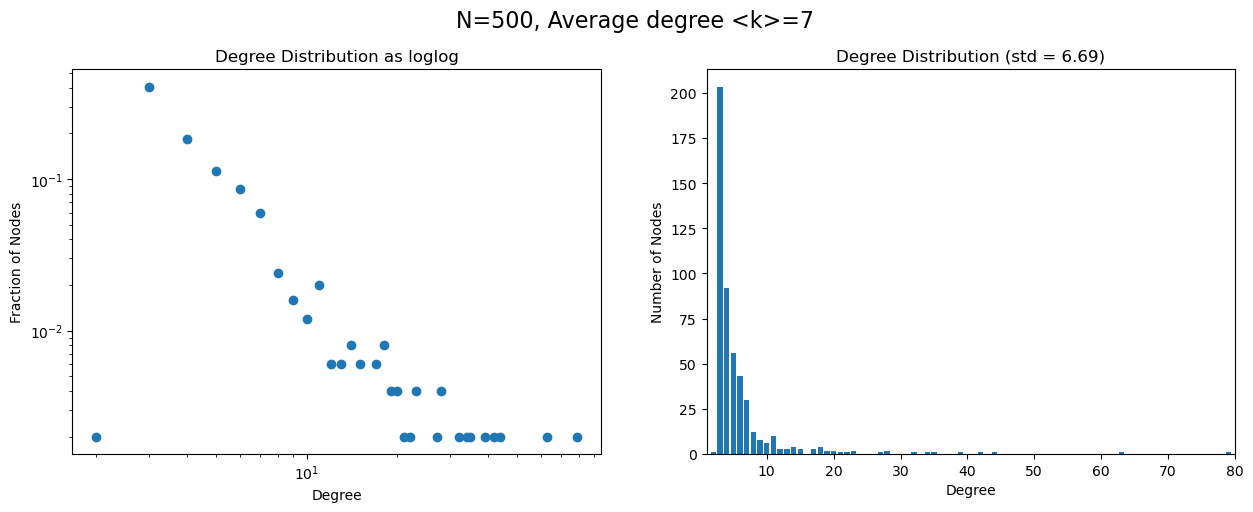

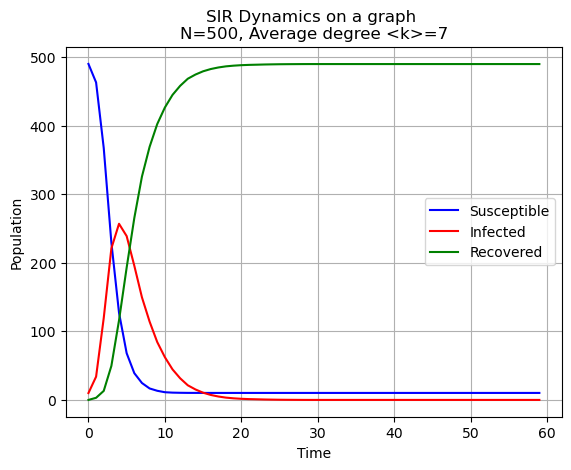

N:500, Average degree <k>=7



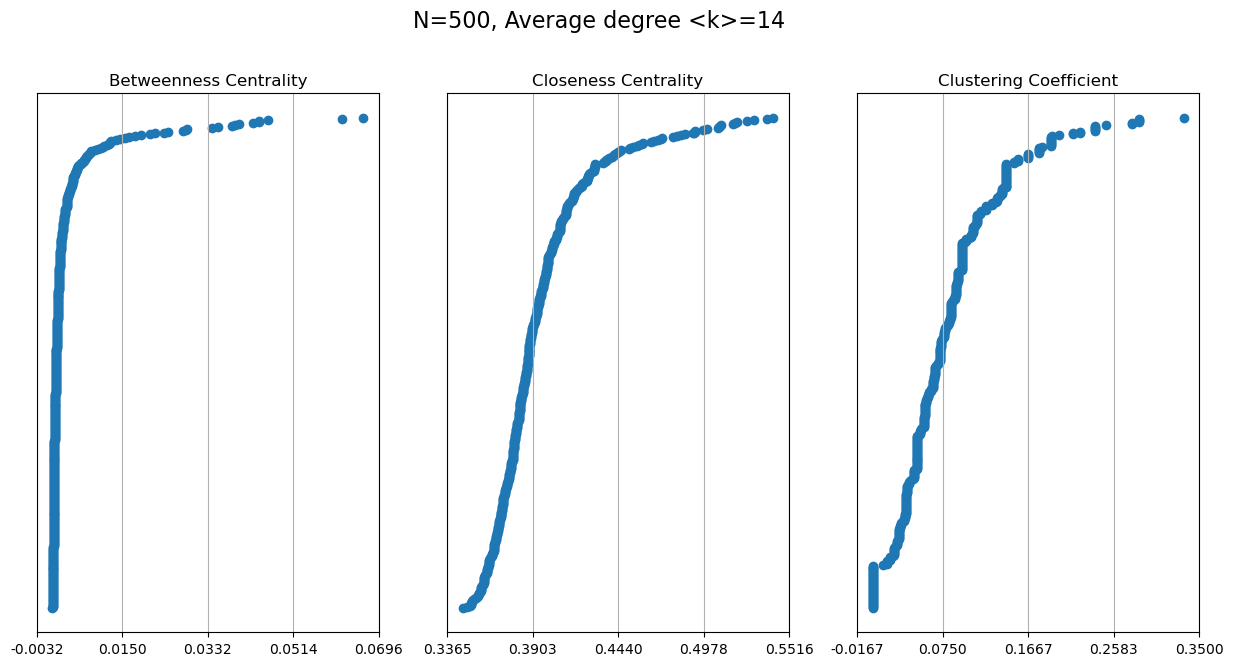

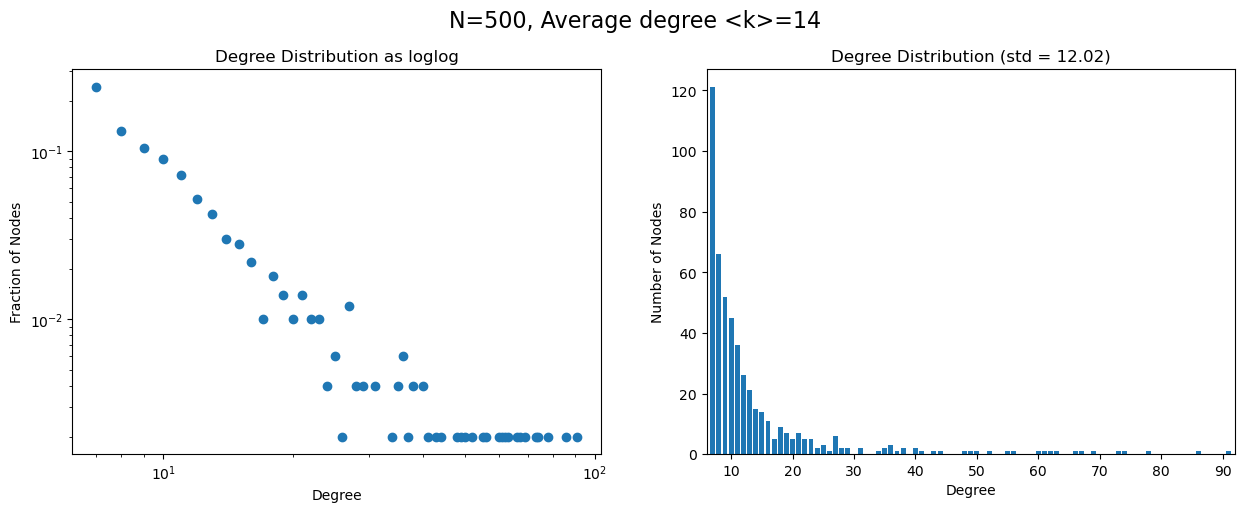

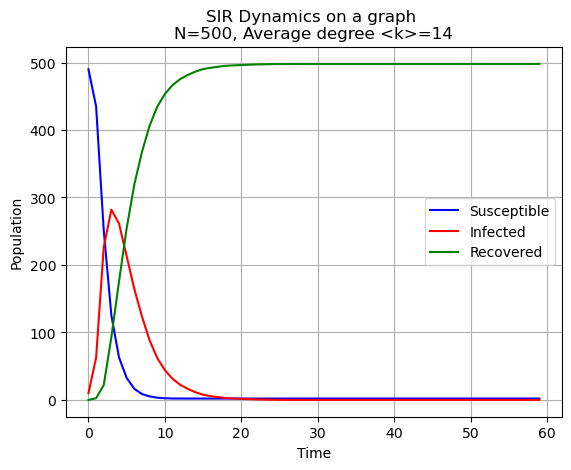

N:500, Average degree <k>=14

CPU times: user 13.2 s, sys: 37 ms, total: 13.2 s
Wall time: 13.2 s


In [31]:
%%time
for N in N_values:
    for avg_degree in average_degrees:
        # allocate memory to create empty lists with a given epoch size 
        history_S = [None] * epochs
        history_I = [None] * epochs
        history_R = [None] * epochs
        history_V = [None] * epochs
        
        barabasi_albert = Network(network_type='barabasi_albert', N=N, avg_degree=avg_degree)
        barabasi_albert.plot_network_statistic(title=f"N={N}, Average degree <k>={avg_degree}")
        barabasi_albert.plot_degree_distribution(title=f"N={N}, Average degree <k>={avg_degree}")

        model = barabasi_albert.create_model(beta=beta, gamma=gamma, num_infected=num_infected)
        # values should be 0 otherwise vaccination will be takin into account
        # the strategy doesn't matter because no vaccinations are going to happen
        barabasi_albert.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                      tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
        for _ in range(epochs):
                S, I, R, vacc_count = barabasi_albert.run_simulation(
                    t=t, beta=beta, gamma=gamma, num_infected=num_infected)
                history_S[_] = S
                history_I[_] = I
                history_R[_] = R
            
        plot_SIR(np.mean(history_S, axis=0), np.mean(history_I, axis=0), np.mean(history_R, axis=0), strategy='', title=f"\nN={N}, Average degree <k>={avg_degree}")
        print(f"N:{N}, Average degree <k>={avg_degree}\n")

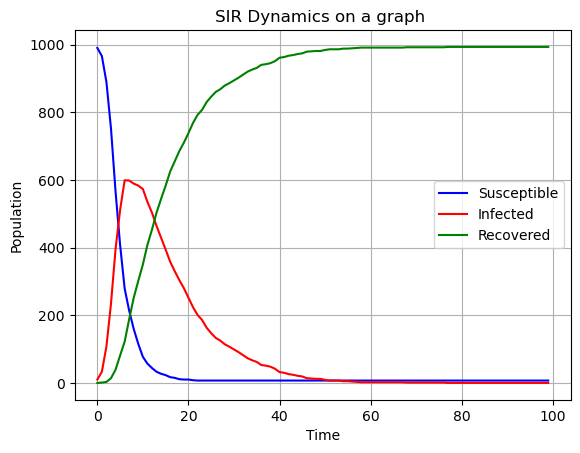

In [32]:
network = Network(network_type='barabasi_albert', N=1000, avg_degree=7)
network.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                      tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
S, I, R, _ = network.run_simulation(t=100, beta=0.3, gamma=0.1, num_infected=num_infected)
plot_SIR(S, I, R, strategy='')

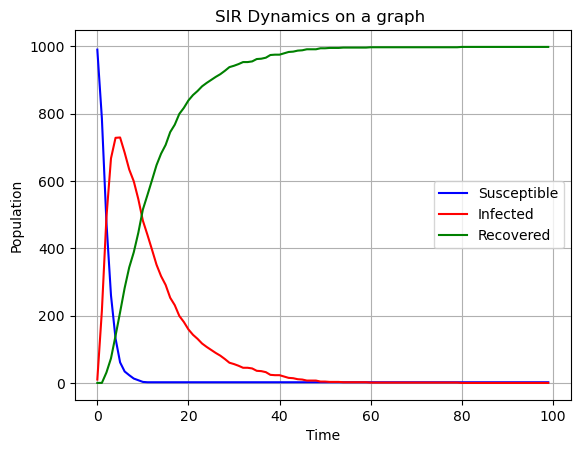

In [33]:
network = Network(network_type='barabasi_albert', N=1000, avg_degree=7)
network.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                      tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
S, I, R, _ = network.run_simulation(t=100, beta=0.5, gamma=0.1, num_infected=num_infected, infect_hubs_only=True)
plot_SIR(S, I, R, strategy='')

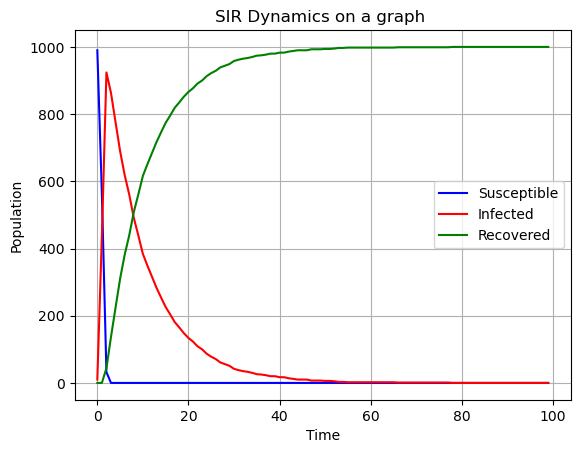

In [34]:
network = Network(network_type='barabasi_albert', N=1000, avg_degree=7)
network.vaccination_setup(vacc_total=0, vacc_num=0, vacc_inter=1, tests_total=0,
                                      tests_num=0, tests_inter=1, test_accuracy=0, strategy='random')
S, I, R, _ = network.run_simulation(t=100, beta=1.5, gamma=0.1, num_infected=num_infected, infect_hubs_only=True)
plot_SIR(S, I, R, strategy='')

-----
## Dynamic Vaccination Campaign

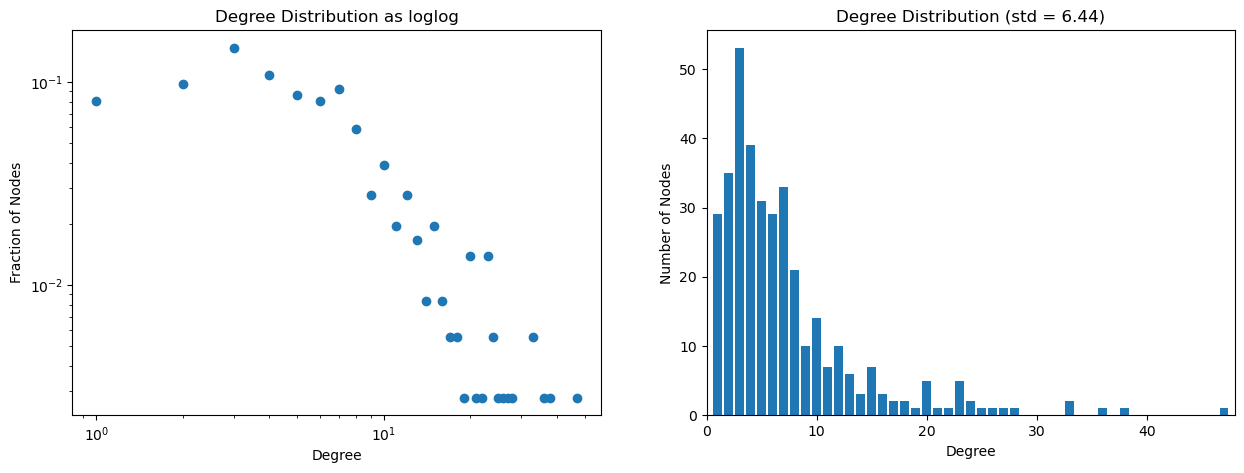

In [35]:
network = Network()
network.plot_degree_distribution()

In [38]:
%%time
epochs = 10
INTERVALL = 4
data = {}
strategies = ['random', 'degree', 'betweenness', 'closeness']

vaccination_budgets = [0, 1, 3, 5, 10]
testing_accuracies = [0, 0.5, 0.75, 1.0]
for strategy in strategies:
    data[strategy] = {}
    for budget in vaccination_budgets:
        data[strategy][budget] = {}
        for test_accuracy in testing_accuracies:
            # allocate memory to create empty lists with a given epoch size 
            history_S = [None] * epochs
            history_I = [None] * epochs
            history_R = [None] * epochs
            history_V = [None] * epochs
            
            network = Network()
            model = network.create_model(beta=0.3, gamma=0.1, num_infected=10)
            network.vaccination_setup(vacc_total=200, vacc_num=budget, vacc_inter=INTERVALL, tests_total=200,
                                      tests_num=10, tests_inter=INTERVALL, test_accuracy=test_accuracy, strategy=strategy)
            
            for _ in range(epochs):
                S, I, R, vacc_count = network.run_simulation(
                    t=100, beta=0.3, gamma=0.1, num_infected=10)
                history_S[_] = S
                history_I[_] = I
                history_R[_] = R
                history_V[_] = vacc_count

            data[strategy][budget][test_accuracy] = np.mean([max(I) for I in history_I])

CPU times: user 4min 46s, sys: 34.6 ms, total: 4min 46s
Wall time: 4min 46s


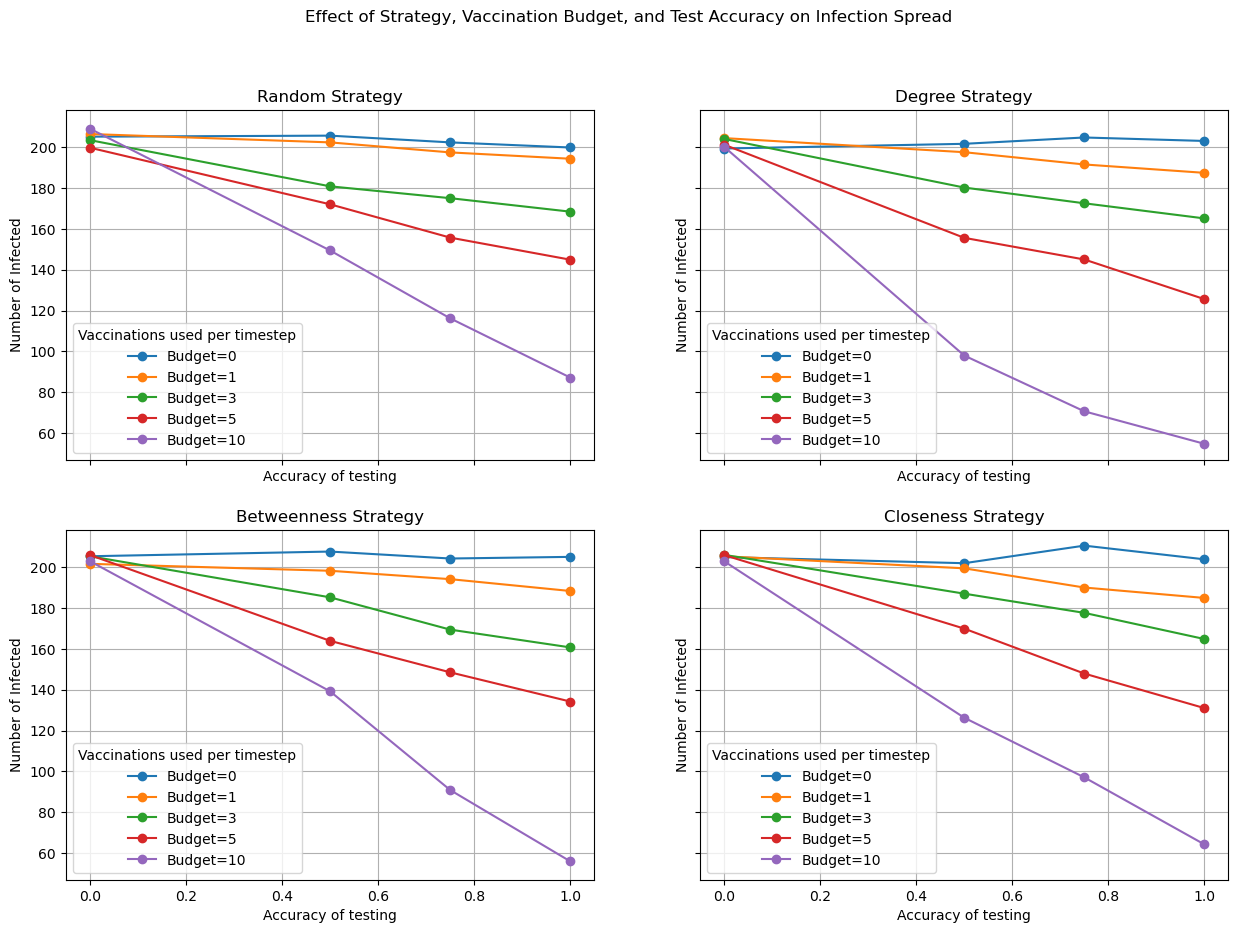

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Effect of Strategy, Vaccination Budget, and Test Accuracy on Infection Spread')

for idx, strategy in enumerate(strategies):
    row, col = divmod(idx, 2)
    ax = axs[row, col]
    
    for budget in vaccination_budgets:
        infections = [data[strategy][budget][accuracy] for accuracy in testing_accuracies]
        ax.plot(testing_accuracies, infections, label=f'Budget={budget}', marker='o')
        
    ax.set_title(strategy.capitalize() + " Strategy")
    ax.set_xlabel("Accuracy of testing")
    ax.set_ylabel("Number of Infected")
    ax.legend(title="Vaccinations used per timestep")
    ax.grid()

plt.show()